In [166]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
# import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [167]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-52-77.net.auckland.ac.nz


In [168]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [169]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().mean()
print('Dataset std: ',  gw_std)

gw_scaling_factor = 5
print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  28.792067898778328
Dataset scaling factor (to match noise in generator):  5


Dataset mean:  -0.35765532
Dataset std:  34.53718
Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 1, 512])


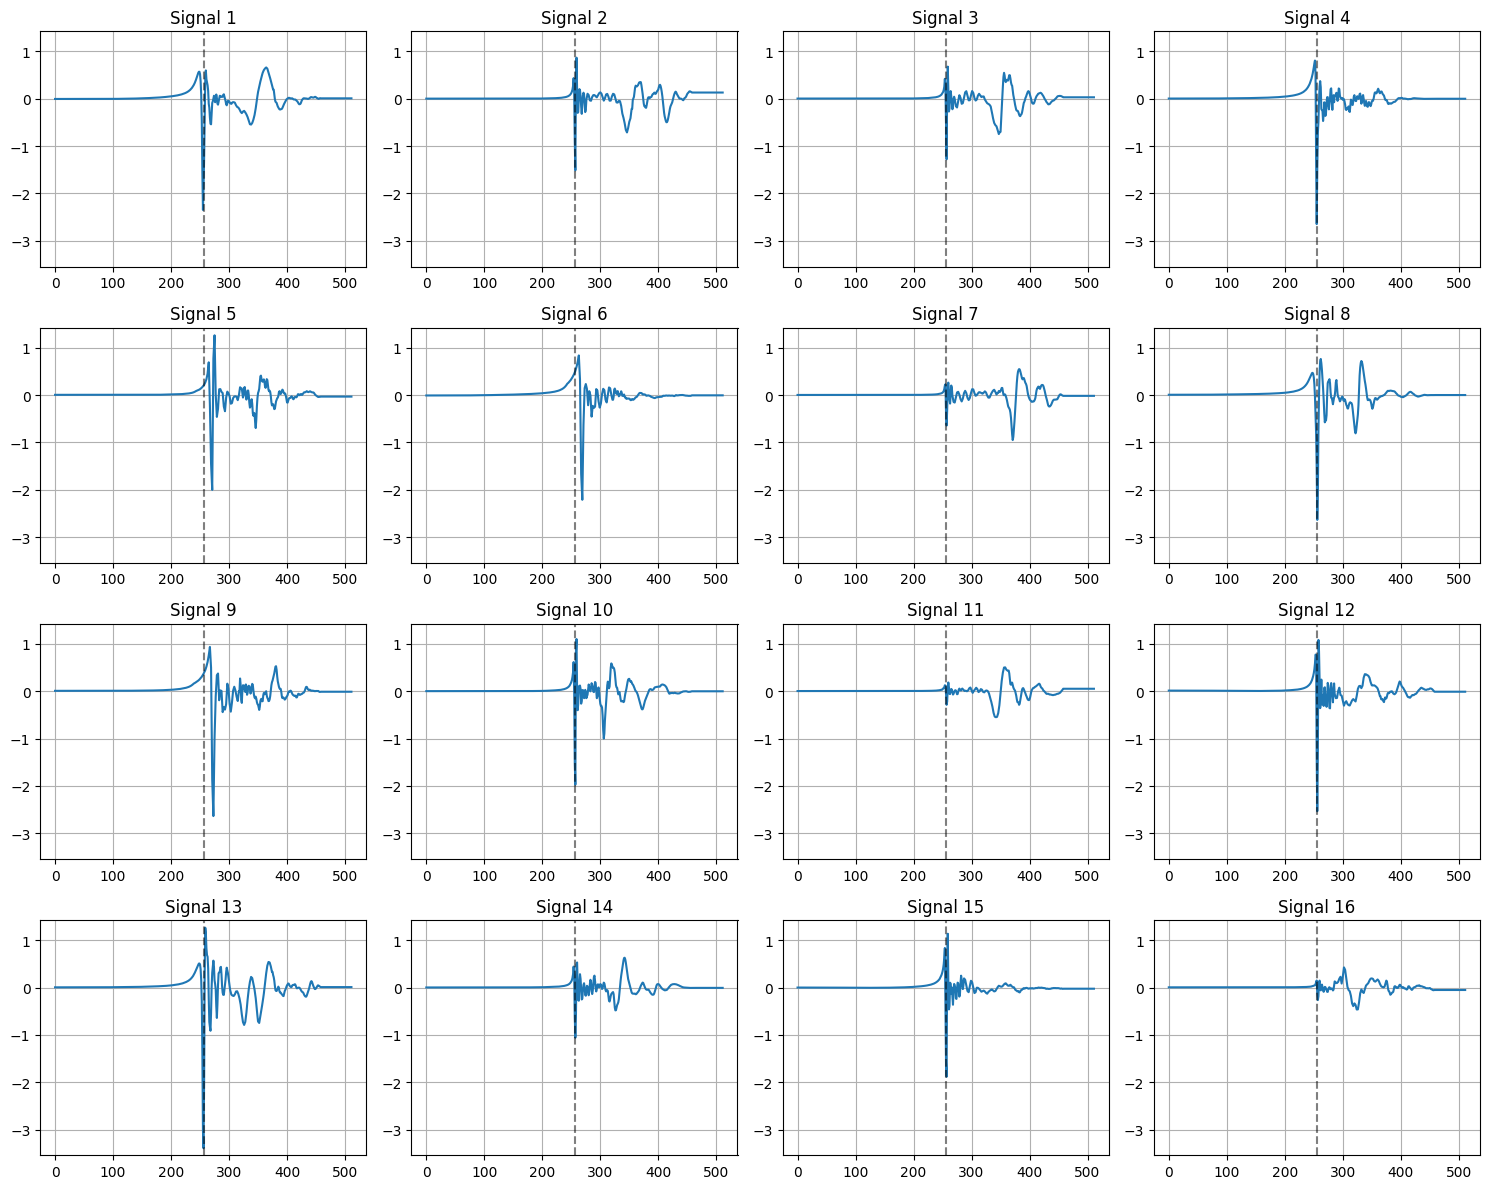

In [205]:
class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal

        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203

        # noise = np.random.normal(0, 0.05, signal.shape[1] - noise_start_time)
        # jittered_signal = signal[noise_start_time:] + noise
        noise = np.random.normal(0, 5, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 180

        # take window size of 10% of the signal with a warping factor for 2 (from literature)
        window_size = math.floor(signal.shape[1] / 10)
        warping_factor = 2
        scaled_window_size = warping_factor * window_size

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]
            # print(signal_after_window)

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        augmented_signals = self.data.copy()

        while augmented_signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.randint(0, self.data.shape[1])
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        # distance = 3.086e22
        # signal = signal / distance

        # pad signals with edge values to be length 512
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
common_ylim_signal = dataset.get_common()
# dataset.pad_signals()
dataset.augmentation(6000)
dataset.calc_stats()
# dataset.standardize()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

In [171]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [172]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [173]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [174]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [175]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [176]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [177]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/20][0/188]	Loss_D: 2.2163	Loss_G: 0.7496	D(x): 0.3720	D(G(z)): 0.3985 / 0.3813
[0/20][50/188]	Loss_D: 0.8341	Loss_G: 2.7767	D(x): 0.1524	D(G(z)): 0.6958 / 0.7083
[0/20][100/188]	Loss_D: 1.0151	Loss_G: 2.5001	D(x): 0.1076	D(G(z)): 0.7509 / 0.7261
[0/20][150/188]	Loss_D: 0.5458	Loss_G: 2.3517	D(x): 0.1427	D(G(z)): 0.7278 / 0.7356


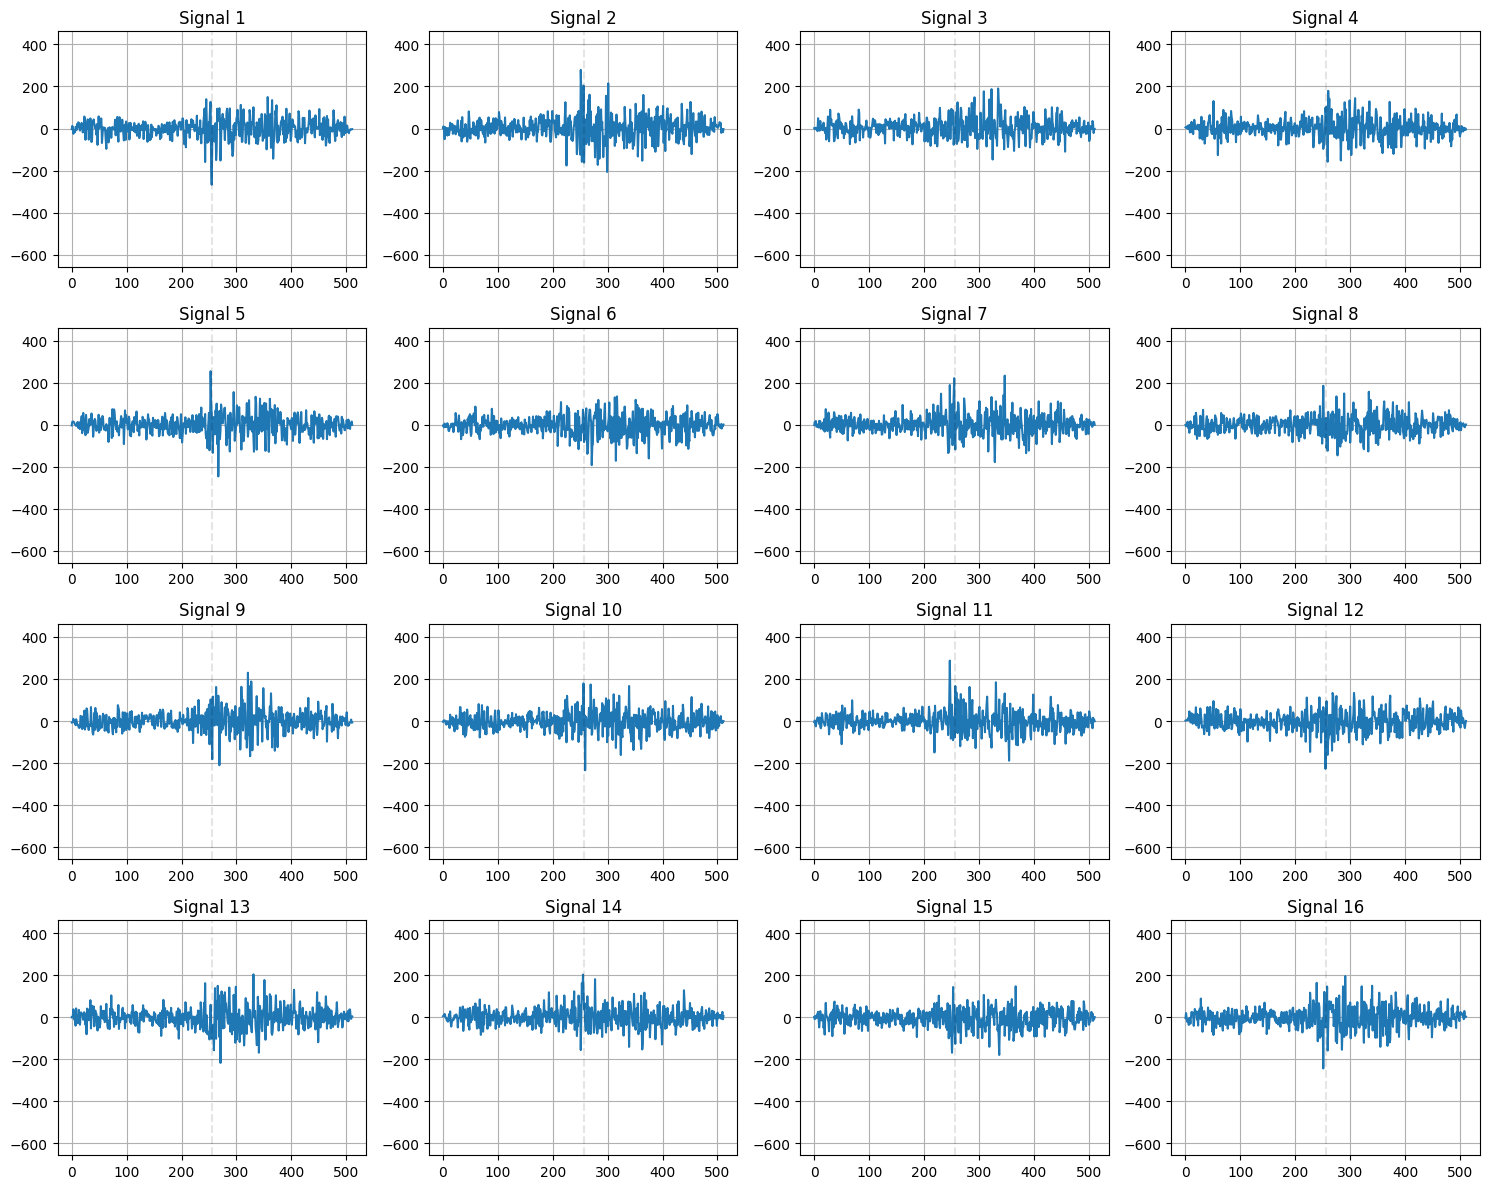

[1/20][0/188]	Loss_D: 0.8665	Loss_G: 2.8888	D(x): 0.1088	D(G(z)): 0.7357 / 0.7818
[1/20][50/188]	Loss_D: 1.0657	Loss_G: 3.4566	D(x): 0.1964	D(G(z)): 0.8358 / 0.8183
[1/20][100/188]	Loss_D: 1.1812	Loss_G: 3.2486	D(x): 0.1127	D(G(z)): 0.7037 / 0.7669
[1/20][150/188]	Loss_D: 0.4485	Loss_G: 2.0584	D(x): 0.1324	D(G(z)): 0.8129 / 0.6586


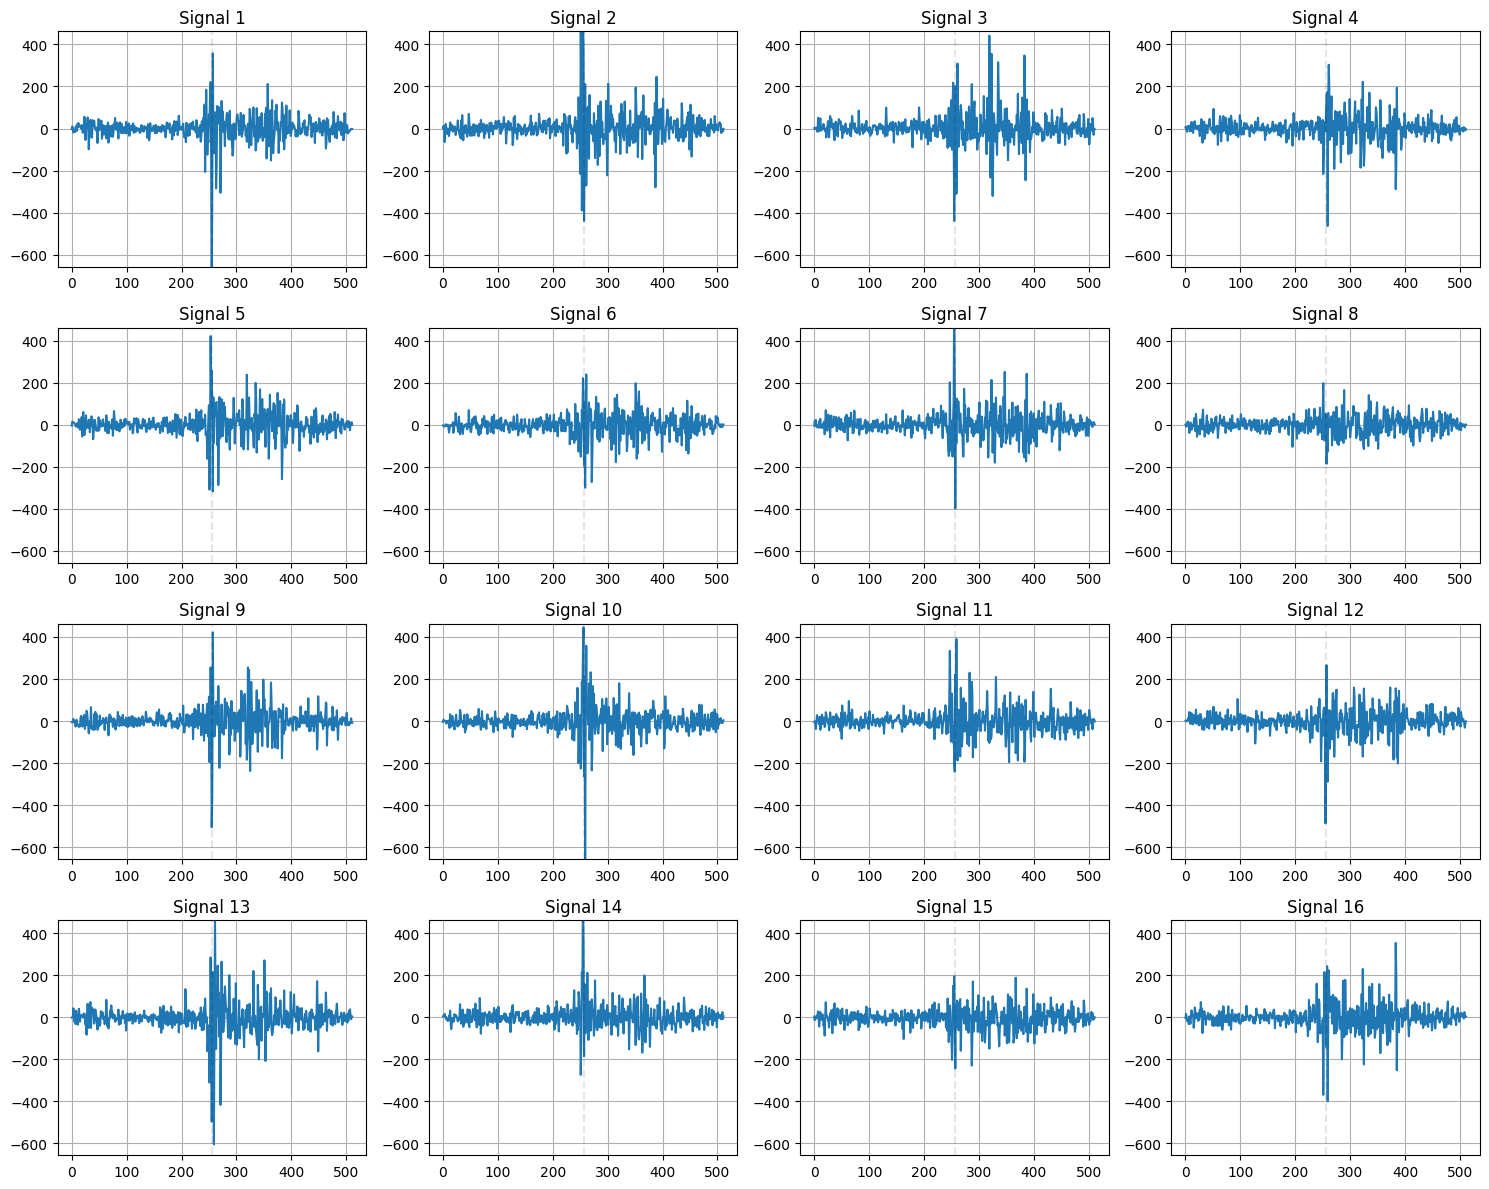

[2/20][0/188]	Loss_D: 0.8257	Loss_G: 2.9180	D(x): 0.1723	D(G(z)): 0.7693 / 0.7771
[2/20][50/188]	Loss_D: 0.6363	Loss_G: 1.9696	D(x): 0.1305	D(G(z)): 0.6822 / 0.6518
[2/20][100/188]	Loss_D: 1.0989	Loss_G: 2.7874	D(x): 0.1384	D(G(z)): 0.7443 / 0.7480
[2/20][150/188]	Loss_D: 0.7365	Loss_G: 2.5365	D(x): 0.1761	D(G(z)): 0.6712 / 0.7638


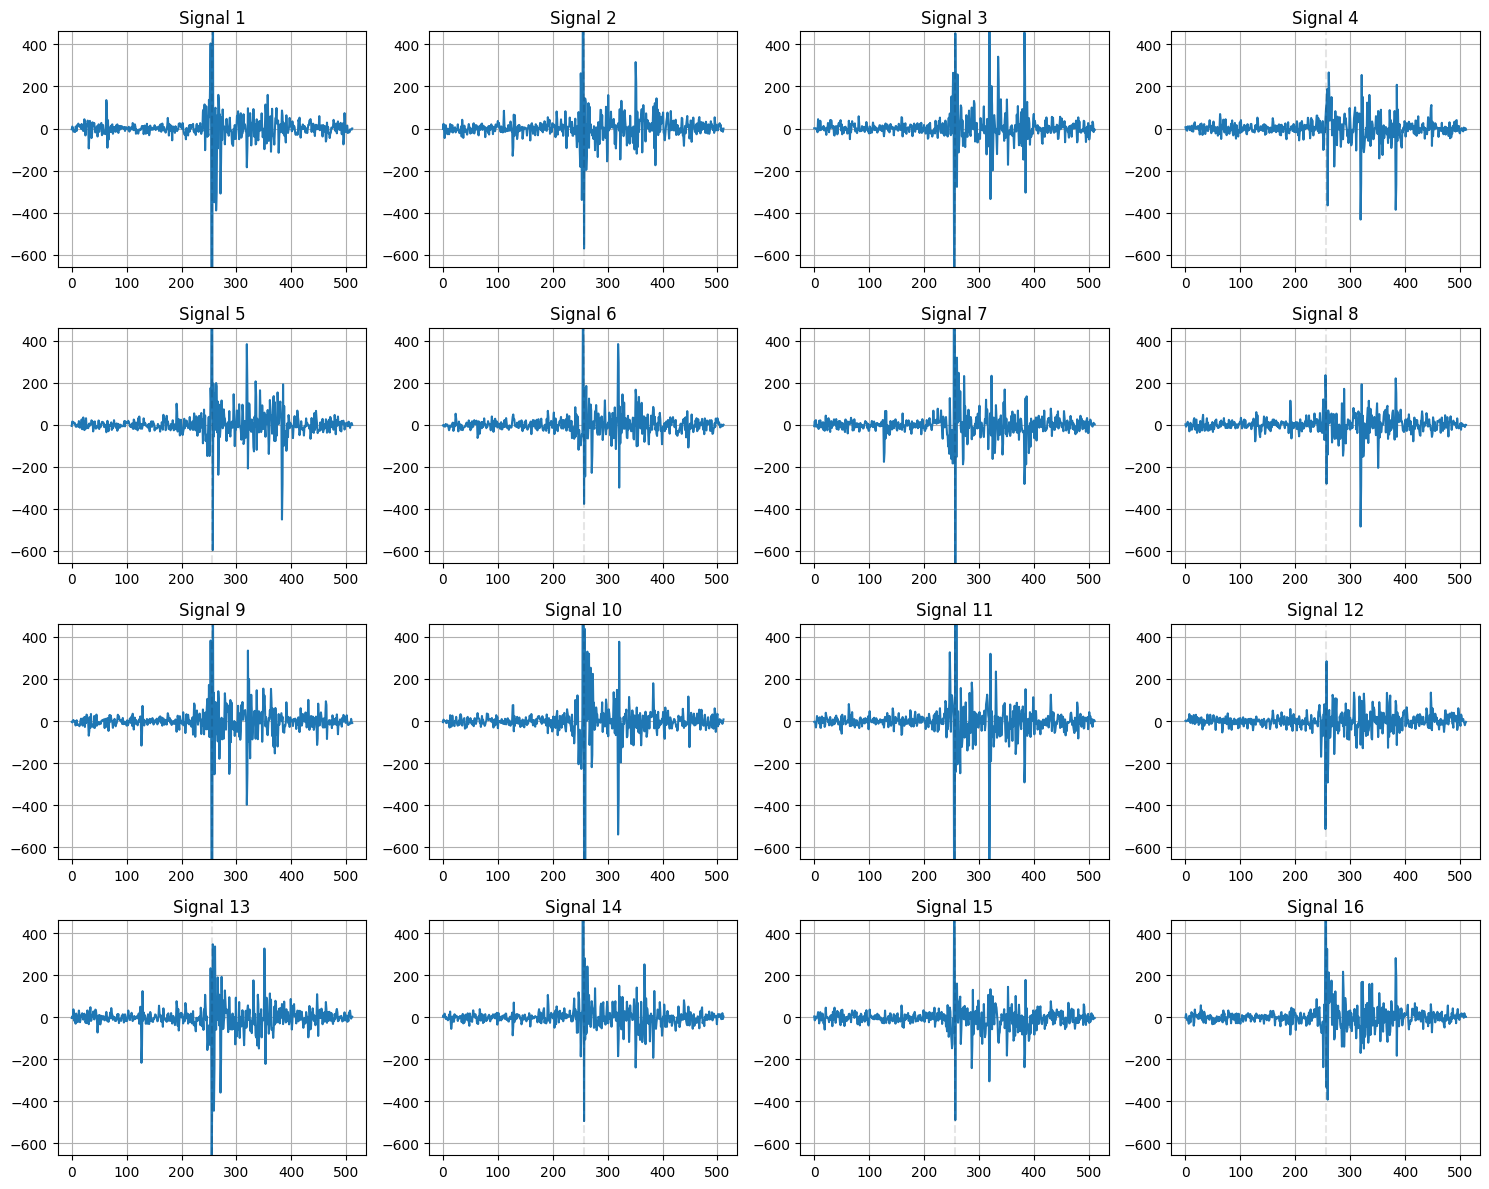

[3/20][0/188]	Loss_D: 0.8547	Loss_G: 2.8430	D(x): 0.1446	D(G(z)): 0.7991 / 0.7629
[3/20][50/188]	Loss_D: 0.6574	Loss_G: 2.2720	D(x): 0.1919	D(G(z)): 0.8362 / 0.7248
[3/20][100/188]	Loss_D: 1.0535	Loss_G: 3.4068	D(x): 0.0965	D(G(z)): 0.8655 / 0.8282
[3/20][150/188]	Loss_D: 0.8710	Loss_G: 3.2205	D(x): 0.1460	D(G(z)): 0.7836 / 0.8297


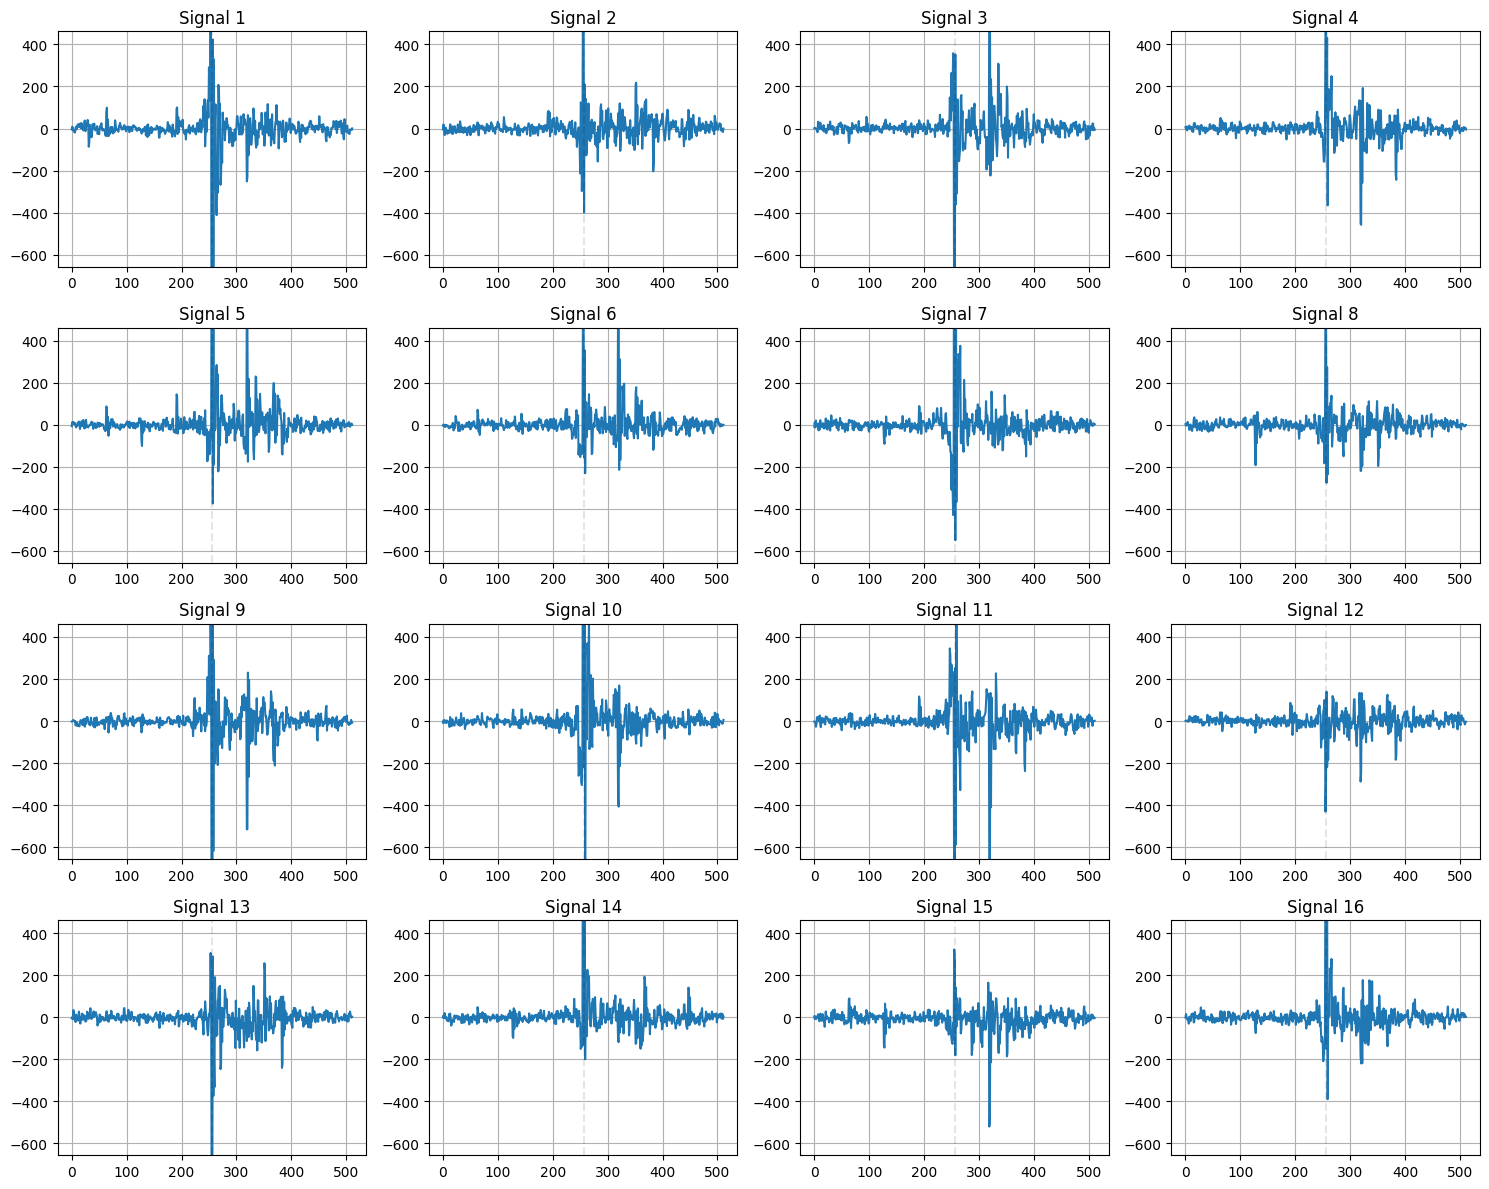

[4/20][0/188]	Loss_D: 0.8534	Loss_G: 3.2251	D(x): 0.2278	D(G(z)): 0.7863 / 0.8336
[4/20][50/188]	Loss_D: 0.5721	Loss_G: 2.1063	D(x): 0.0949	D(G(z)): 0.6762 / 0.7221
[4/20][100/188]	Loss_D: 0.6473	Loss_G: 2.1528	D(x): 0.1453	D(G(z)): 0.7925 / 0.7336
[4/20][150/188]	Loss_D: 0.8589	Loss_G: 3.2744	D(x): 0.0941	D(G(z)): 0.8516 / 0.8408


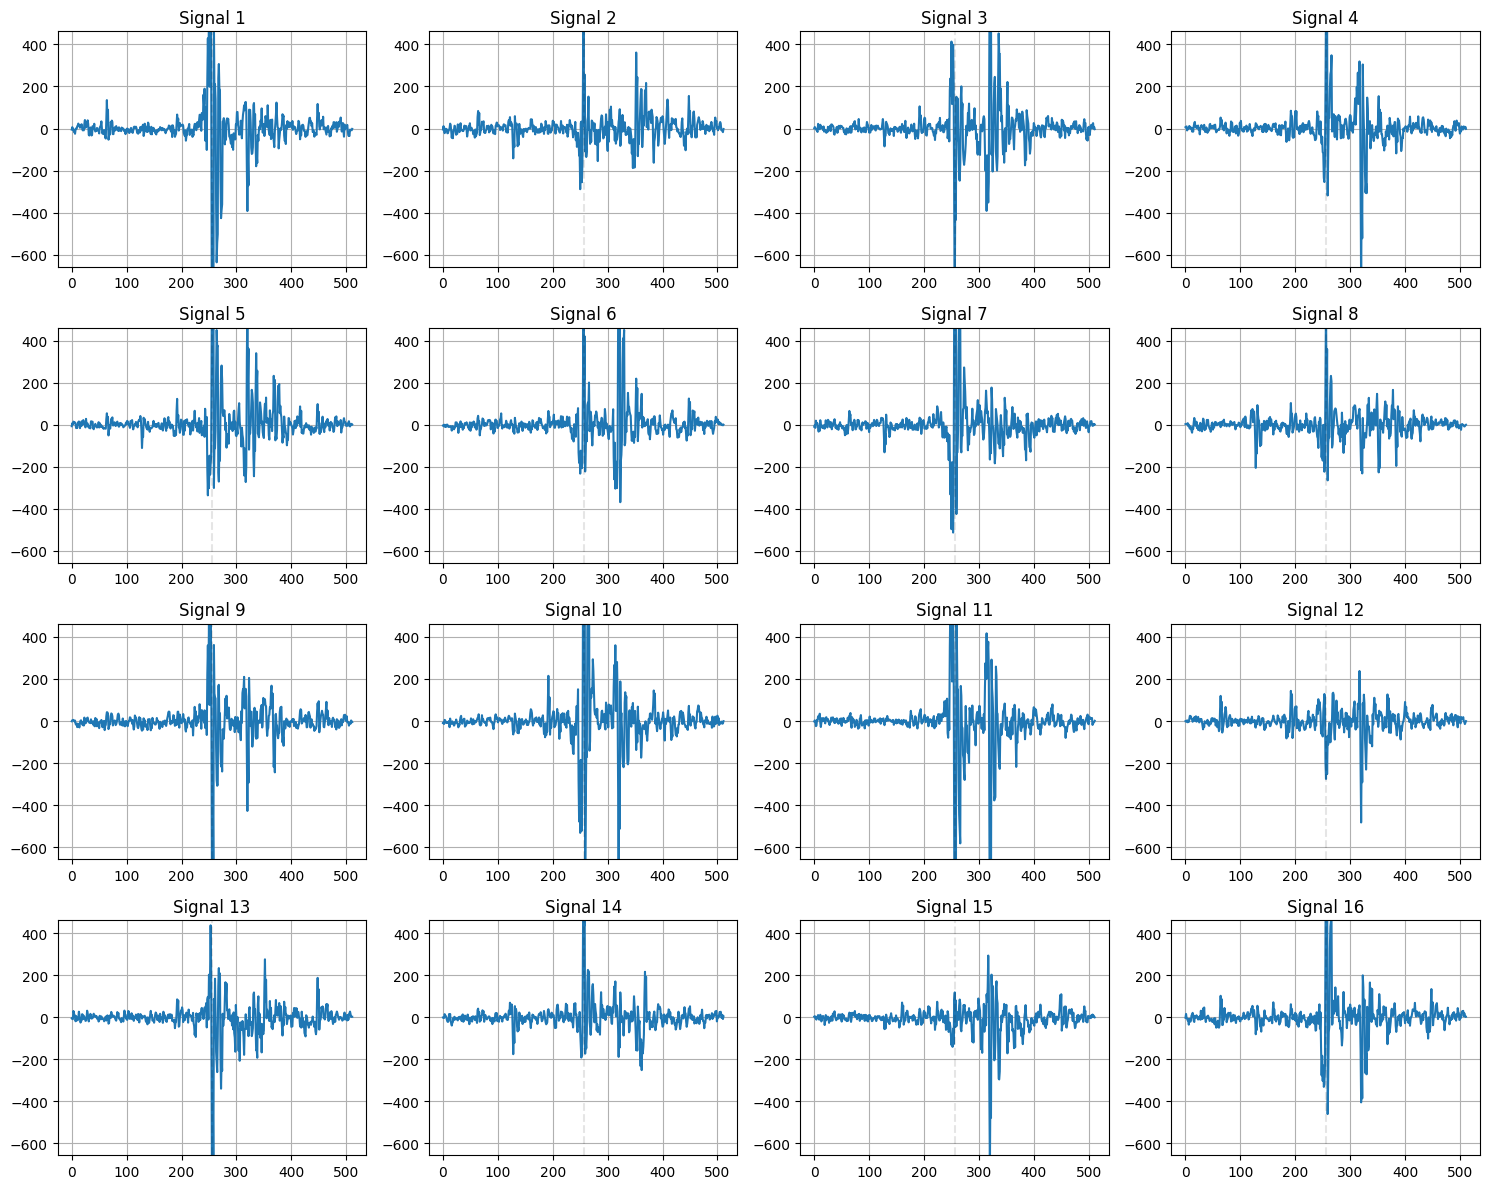

[5/20][0/188]	Loss_D: 1.0776	Loss_G: 2.9494	D(x): 0.1902	D(G(z)): 0.6858 / 0.7891
[5/20][50/188]	Loss_D: 0.9566	Loss_G: 3.1881	D(x): 0.1755	D(G(z)): 0.6673 / 0.8142
[5/20][100/188]	Loss_D: 0.3278	Loss_G: 1.8892	D(x): 0.0989	D(G(z)): 0.8124 / 0.6820
[5/20][150/188]	Loss_D: 0.8608	Loss_G: 3.8374	D(x): 0.1485	D(G(z)): 0.8901 / 0.8252


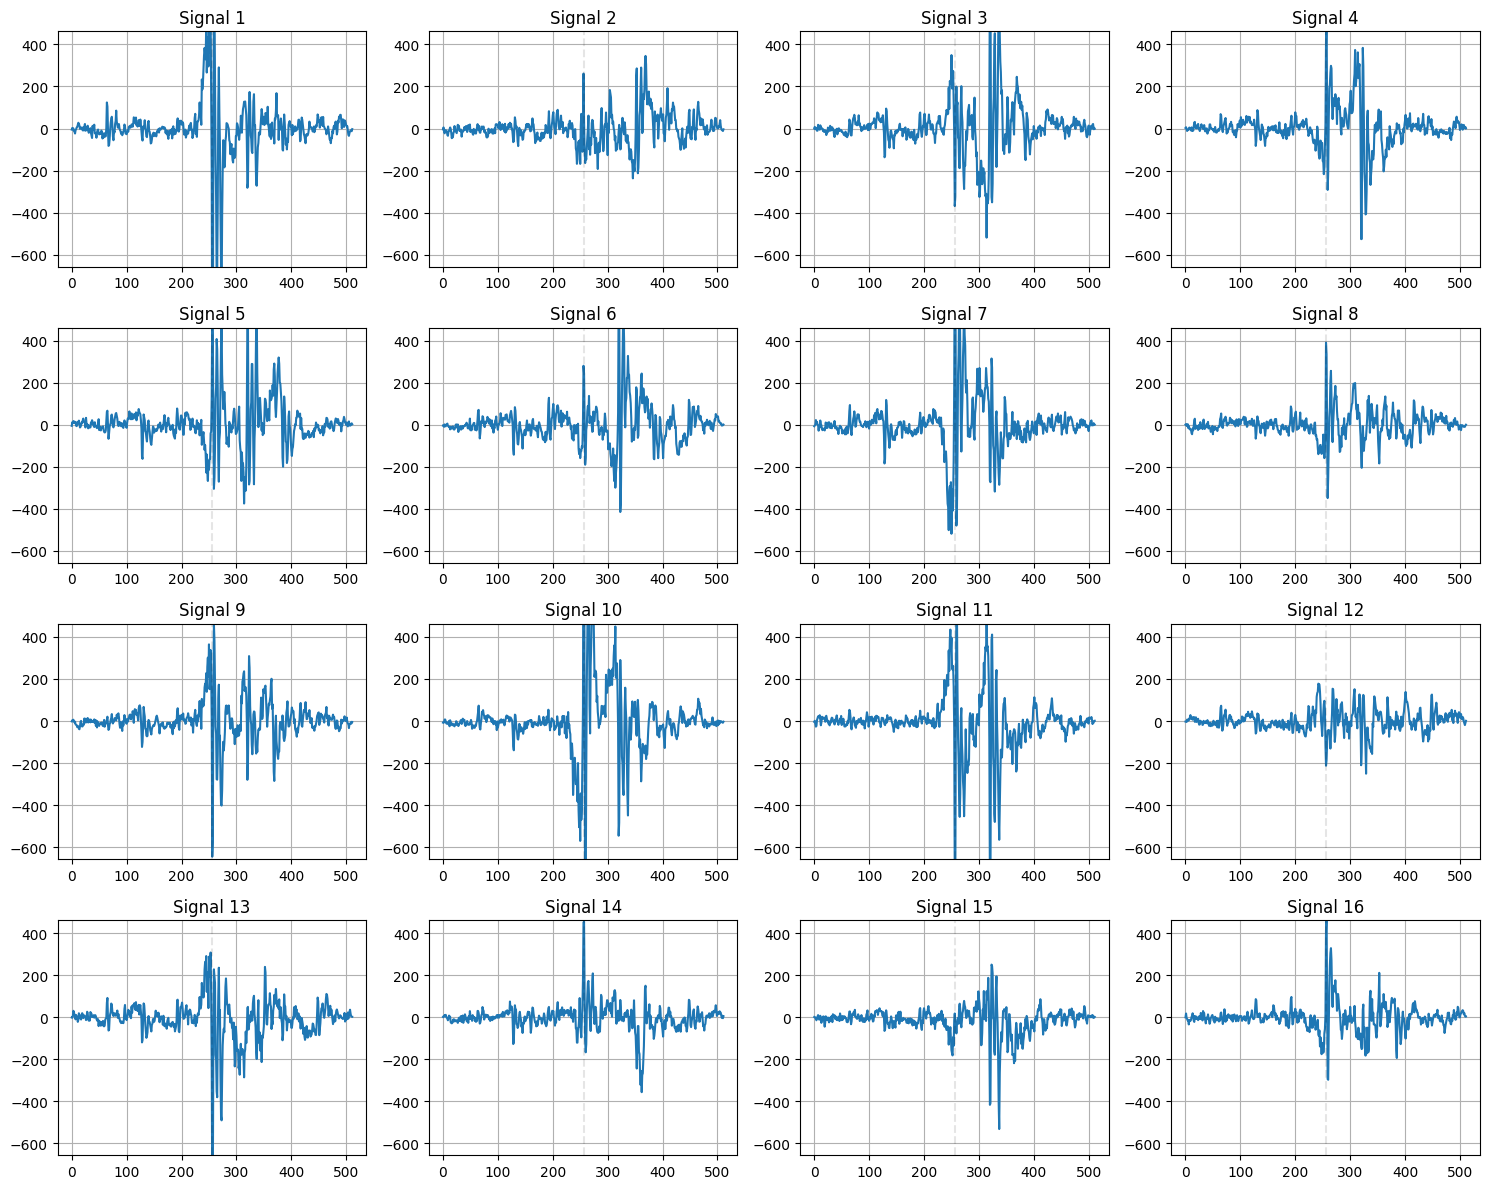

[6/20][0/188]	Loss_D: 0.7193	Loss_G: 2.5314	D(x): 0.1855	D(G(z)): 0.7615 / 0.7855
[6/20][50/188]	Loss_D: 1.0273	Loss_G: 4.2405	D(x): 0.0999	D(G(z)): 0.7307 / 0.8969
[6/20][100/188]	Loss_D: 0.7805	Loss_G: 3.2465	D(x): 0.1759	D(G(z)): 0.7699 / 0.8181
[6/20][150/188]	Loss_D: 0.8364	Loss_G: 1.3155	D(x): 0.2052	D(G(z)): 0.7565 / 0.5848


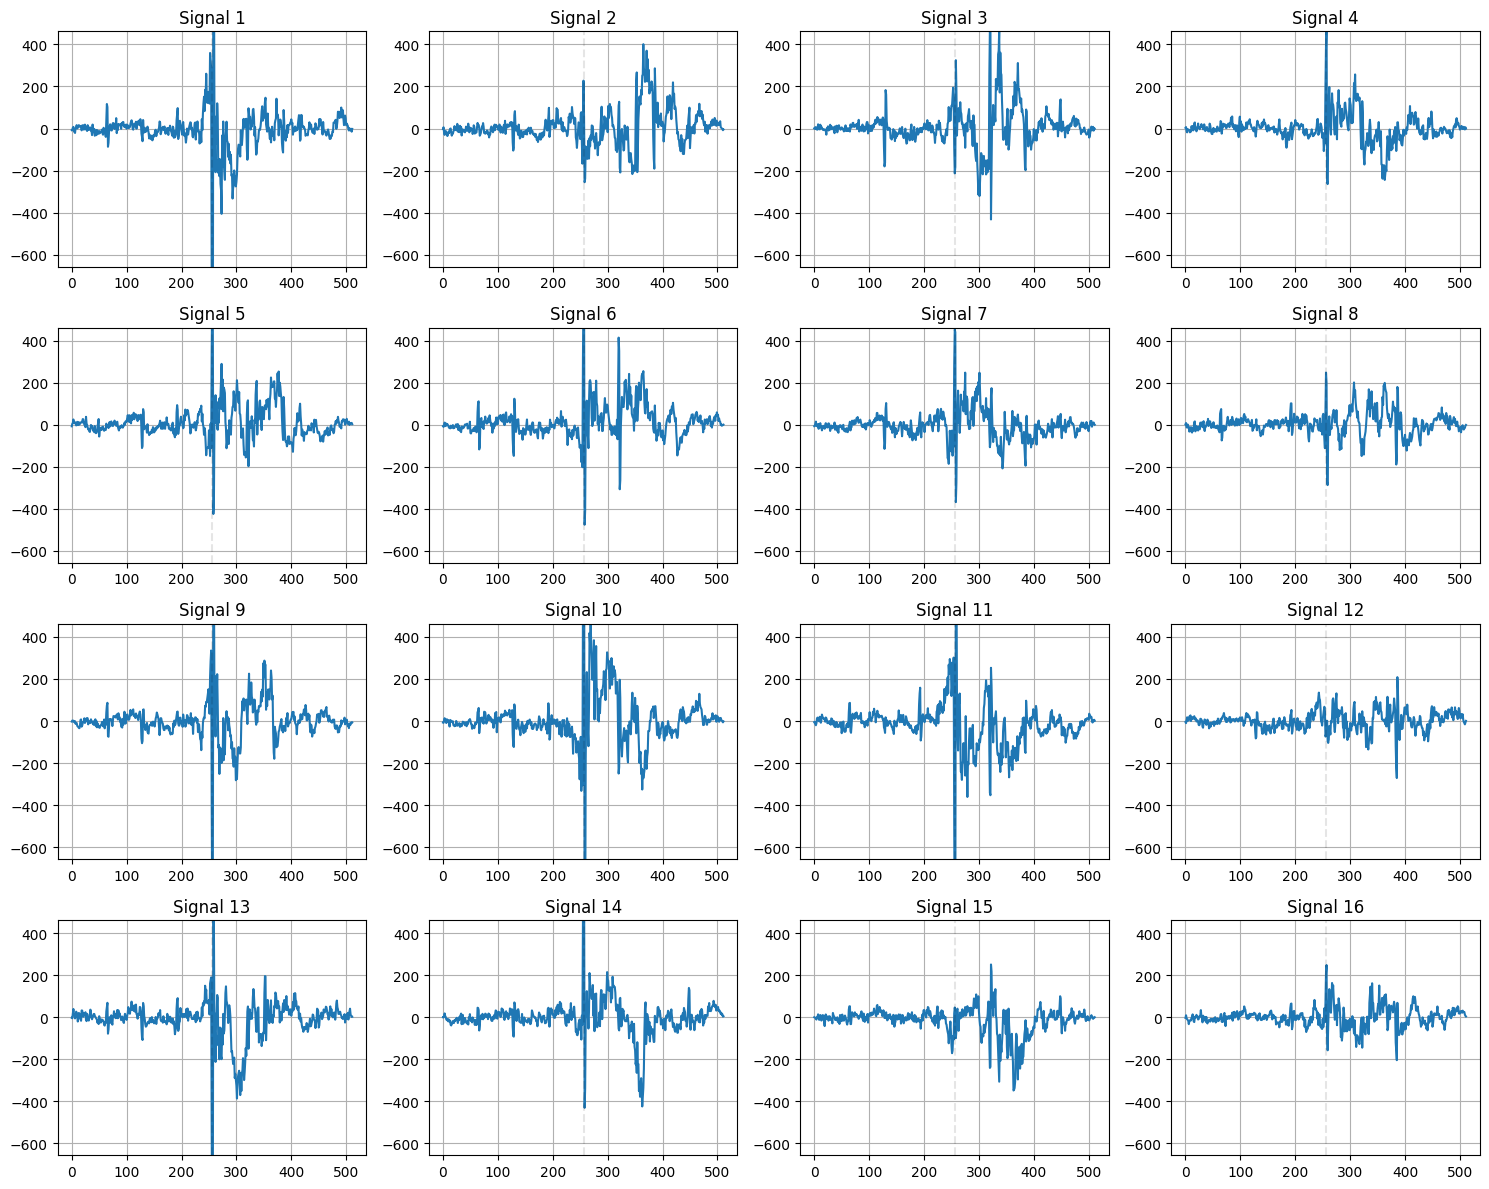

[7/20][0/188]	Loss_D: 0.8633	Loss_G: 4.2699	D(x): 0.1170	D(G(z)): 0.7123 / 0.9031
[7/20][50/188]	Loss_D: 0.8258	Loss_G: 3.9018	D(x): 0.1702	D(G(z)): 0.8588 / 0.8323
[7/20][100/188]	Loss_D: 0.6097	Loss_G: 3.0694	D(x): 0.1403	D(G(z)): 0.8101 / 0.8511
[7/20][150/188]	Loss_D: 0.9070	Loss_G: 1.9796	D(x): 0.1264	D(G(z)): 0.5548 / 0.6551


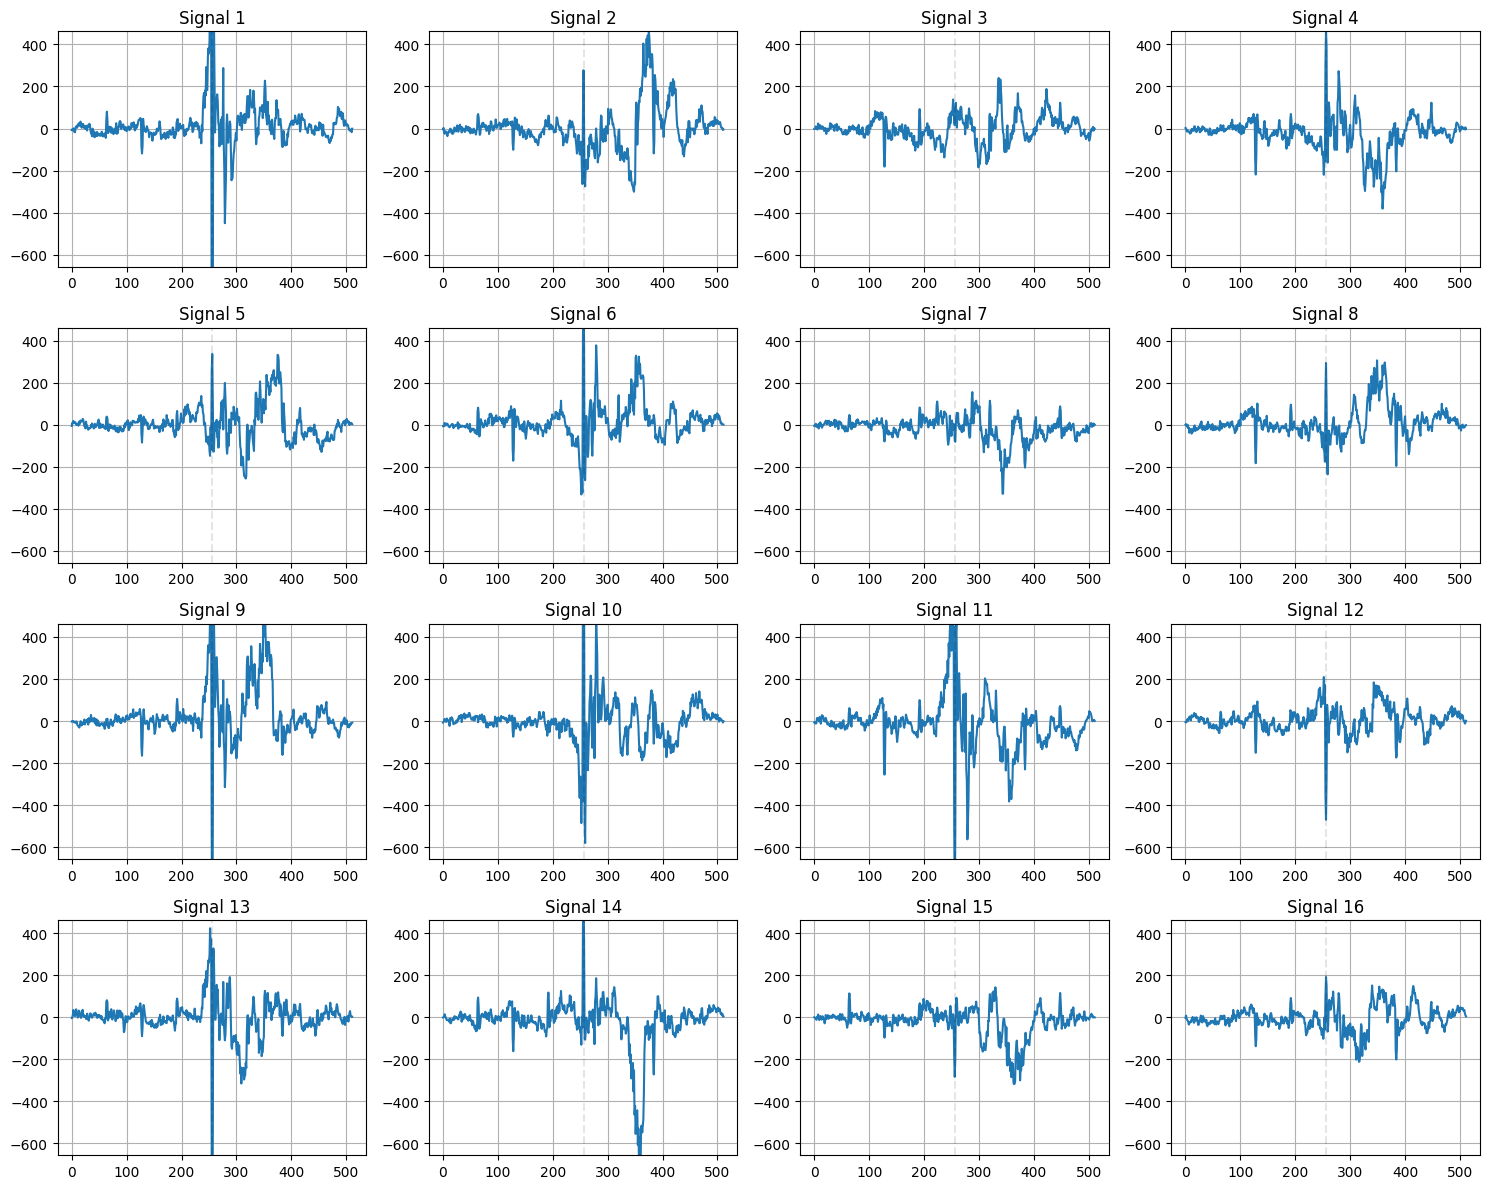

[8/20][0/188]	Loss_D: 1.1308	Loss_G: 3.0000	D(x): 0.2037	D(G(z)): 0.7955 / 0.8305
[8/20][50/188]	Loss_D: 0.9832	Loss_G: 2.2406	D(x): 0.1332	D(G(z)): 0.7018 / 0.7289
[8/20][100/188]	Loss_D: 1.0653	Loss_G: 2.8381	D(x): 0.2320	D(G(z)): 0.7841 / 0.7678
[8/20][150/188]	Loss_D: 1.1892	Loss_G: 2.8591	D(x): 0.1265	D(G(z)): 0.6034 / 0.7799


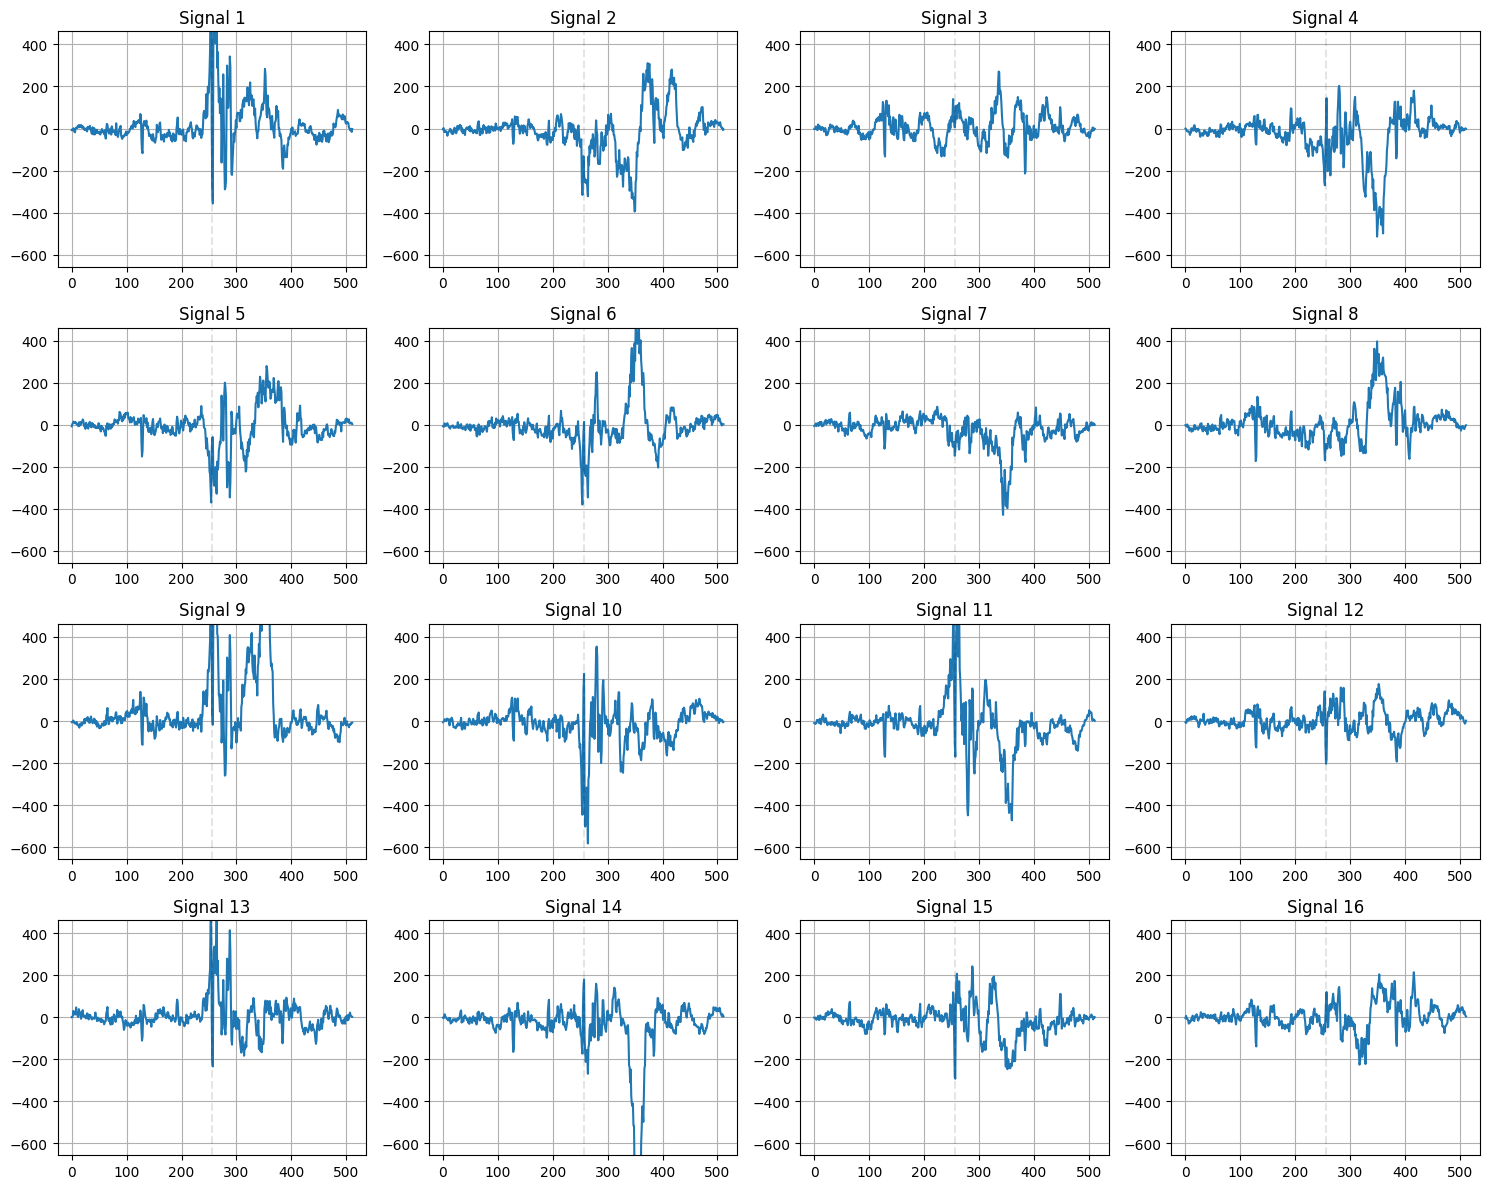

[9/20][0/188]	Loss_D: 0.8437	Loss_G: 2.9425	D(x): 0.1178	D(G(z)): 0.7481 / 0.8164
[9/20][50/188]	Loss_D: 1.1433	Loss_G: 3.0724	D(x): 0.1739	D(G(z)): 0.7432 / 0.7925
[9/20][100/188]	Loss_D: 0.7282	Loss_G: 3.0547	D(x): 0.0818	D(G(z)): 0.7715 / 0.7731
[9/20][150/188]	Loss_D: 0.5832	Loss_G: 2.6185	D(x): 0.1439	D(G(z)): 0.8343 / 0.7823


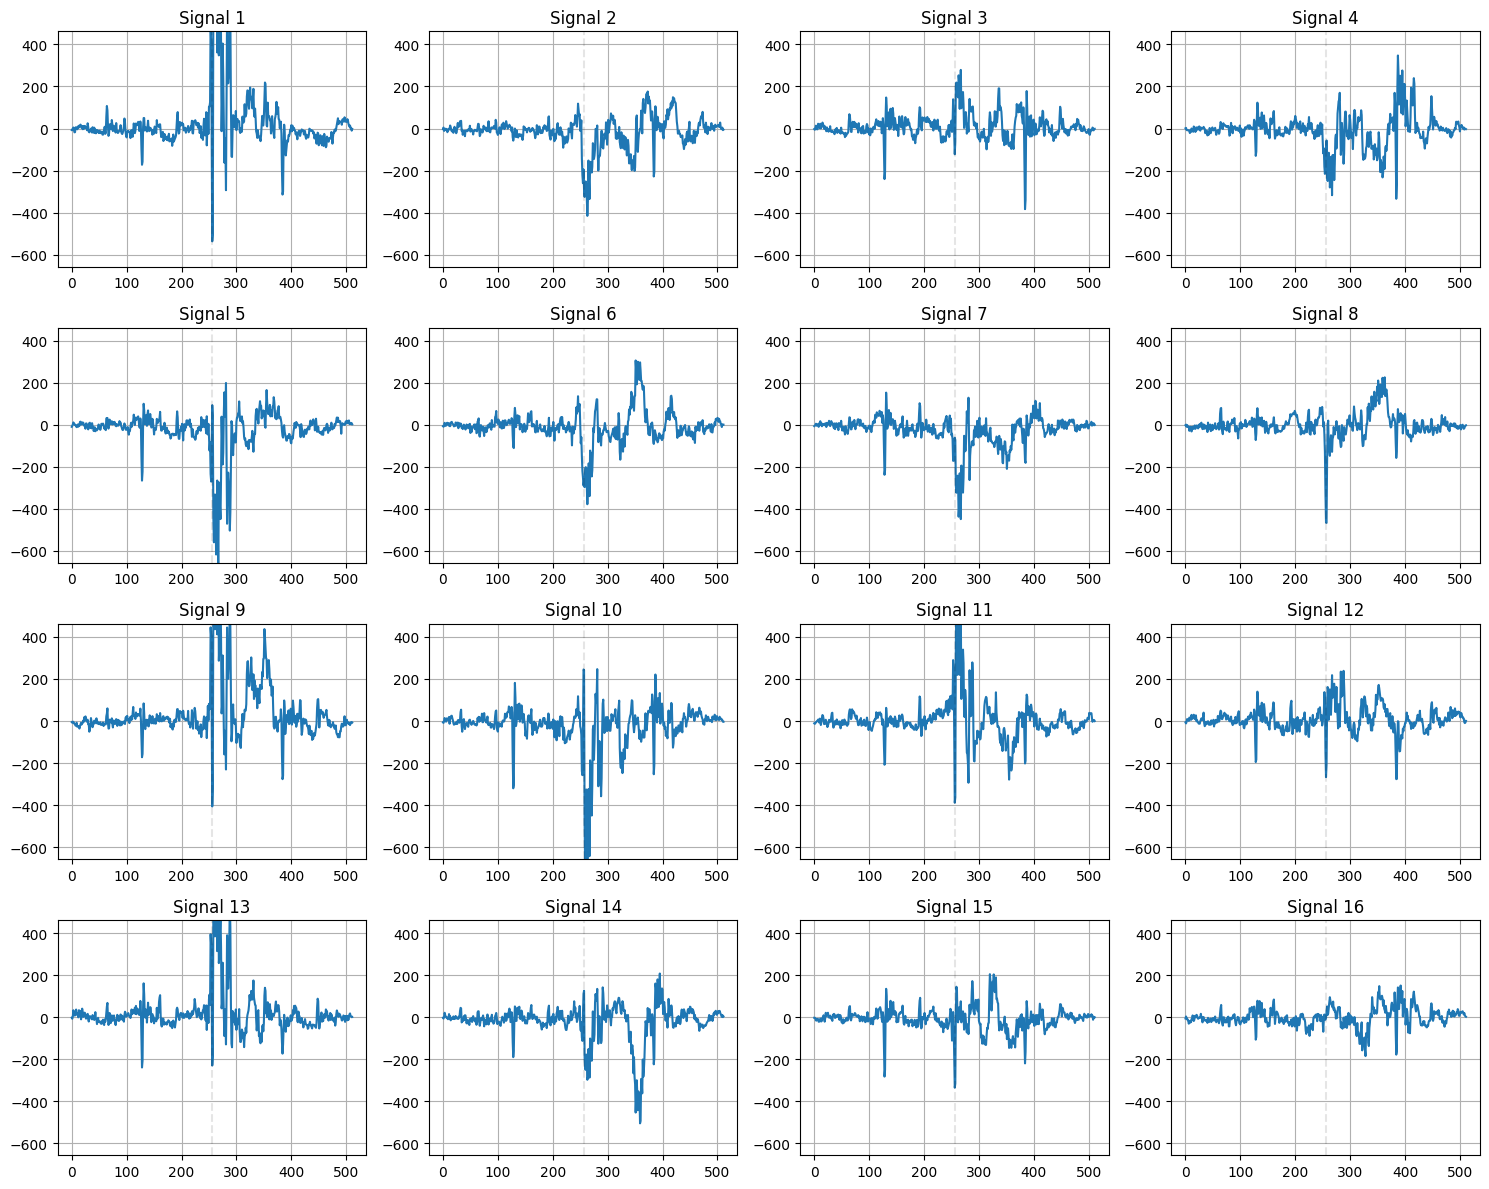

[10/20][0/188]	Loss_D: 0.8528	Loss_G: 2.5759	D(x): 0.1276	D(G(z)): 0.7967 / 0.7842
[10/20][50/188]	Loss_D: 0.7721	Loss_G: 1.3752	D(x): 0.1725	D(G(z)): 0.7911 / 0.6151
[10/20][100/188]	Loss_D: 0.7880	Loss_G: 2.2427	D(x): 0.0900	D(G(z)): 0.8116 / 0.7222
[10/20][150/188]	Loss_D: 0.6663	Loss_G: 4.0020	D(x): 0.1326	D(G(z)): 0.8574 / 0.8582


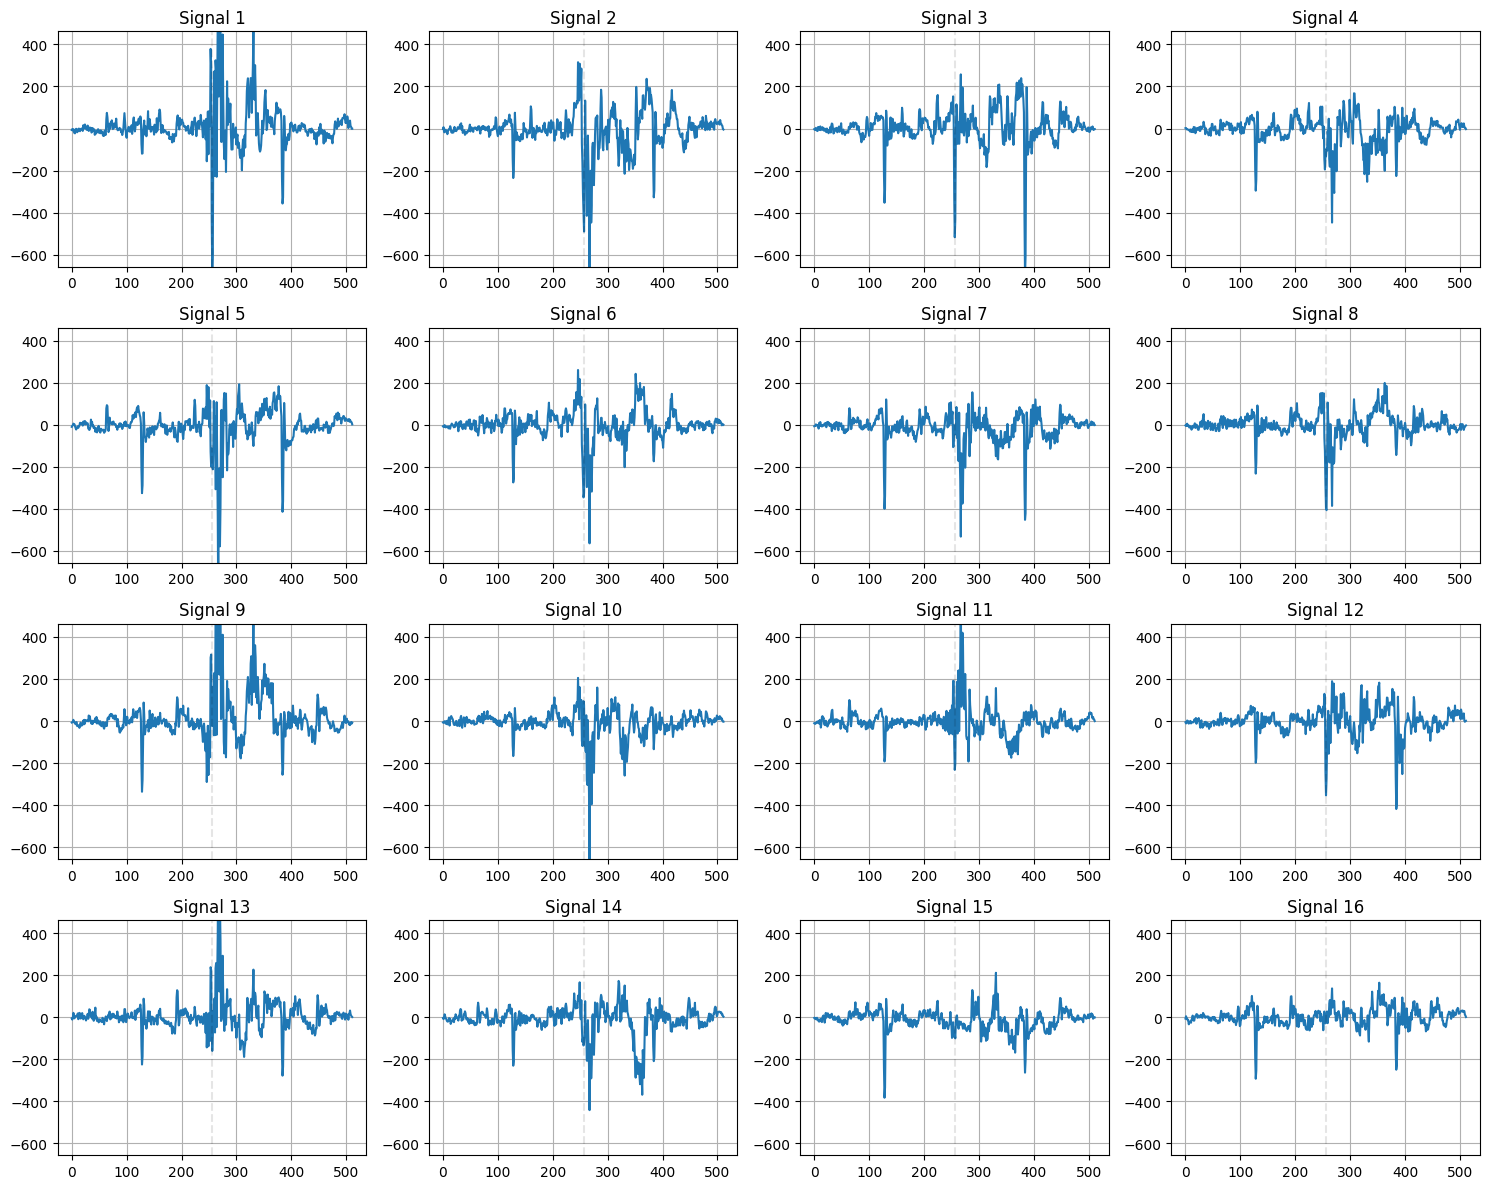

[11/20][0/188]	Loss_D: 0.9511	Loss_G: 3.4799	D(x): 0.2012	D(G(z)): 0.7120 / 0.8877
[11/20][50/188]	Loss_D: 0.8166	Loss_G: 1.3335	D(x): 0.1603	D(G(z)): 0.7761 / 0.6064
[11/20][100/188]	Loss_D: 0.7842	Loss_G: 2.4351	D(x): 0.1810	D(G(z)): 0.7892 / 0.7664
[11/20][150/188]	Loss_D: 1.1003	Loss_G: 3.2765	D(x): 0.1903	D(G(z)): 0.6670 / 0.8248


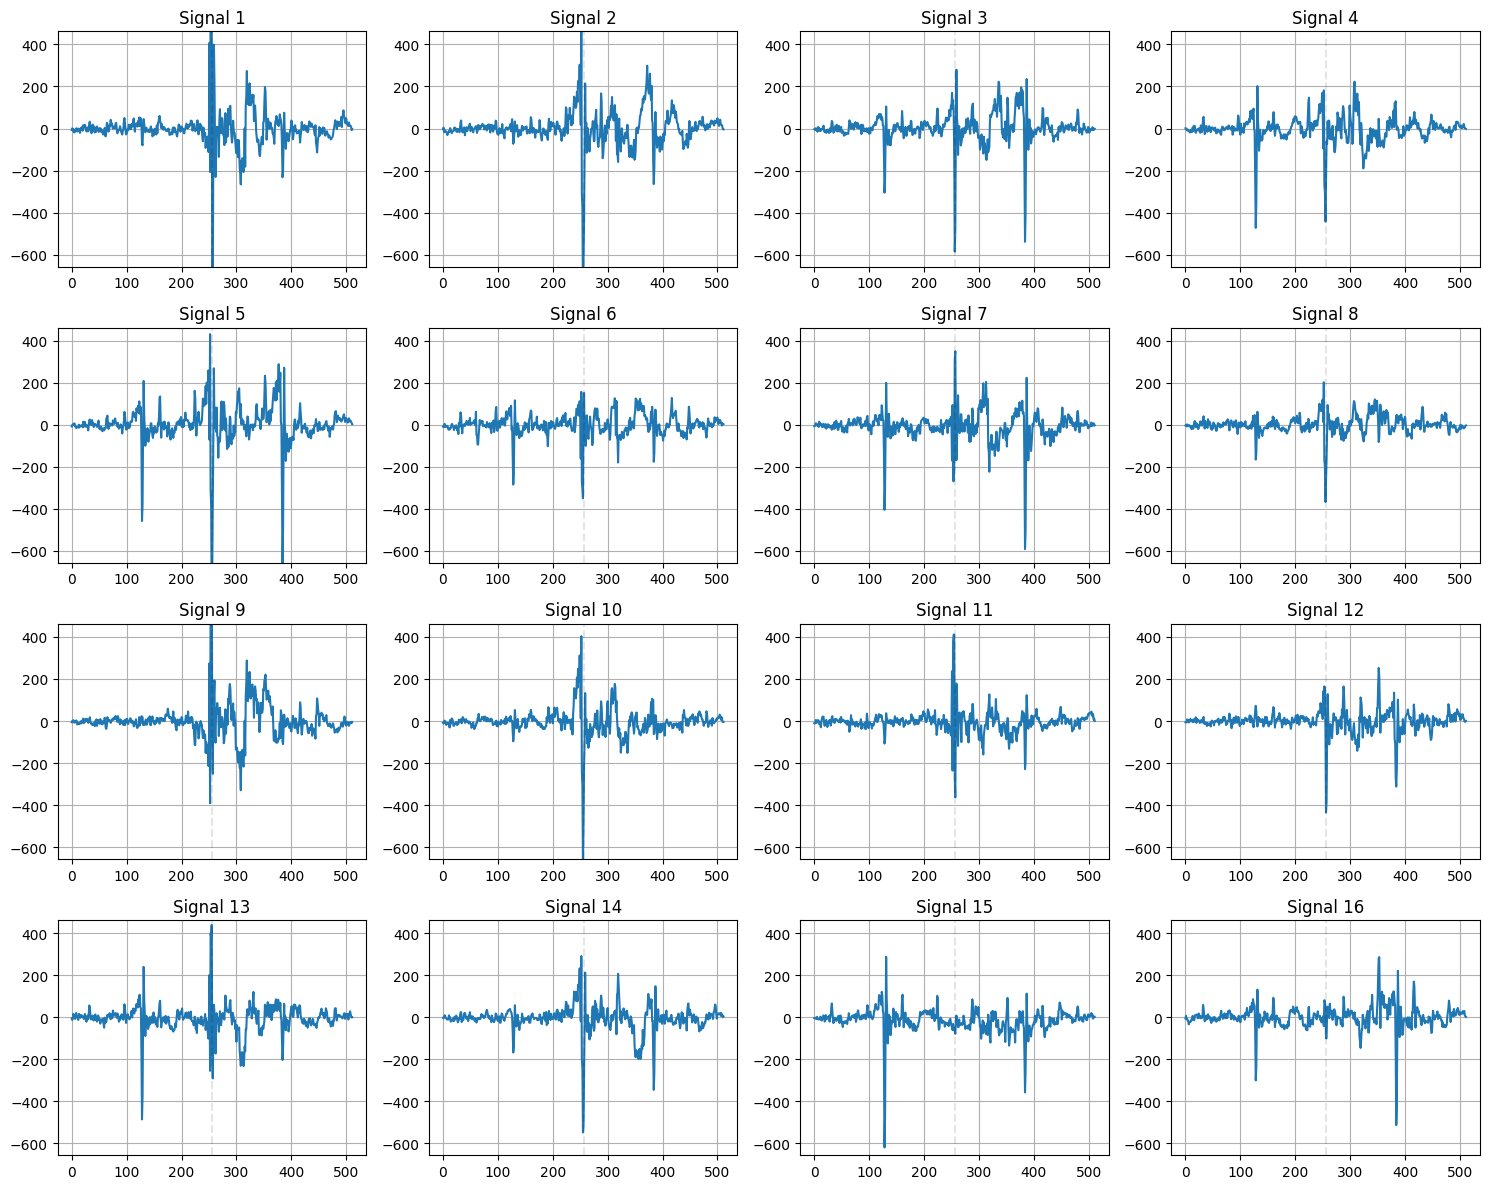

[12/20][0/188]	Loss_D: 0.8431	Loss_G: 3.1407	D(x): 0.1855	D(G(z)): 0.7906 / 0.8884
[12/20][50/188]	Loss_D: 0.6091	Loss_G: 2.6143	D(x): 0.1003	D(G(z)): 0.8112 / 0.7685
[12/20][100/188]	Loss_D: 0.9785	Loss_G: 3.2831	D(x): 0.1043	D(G(z)): 0.9180 / 0.8529
[12/20][150/188]	Loss_D: 0.9052	Loss_G: 2.4829	D(x): 0.2048	D(G(z)): 0.7684 / 0.7971


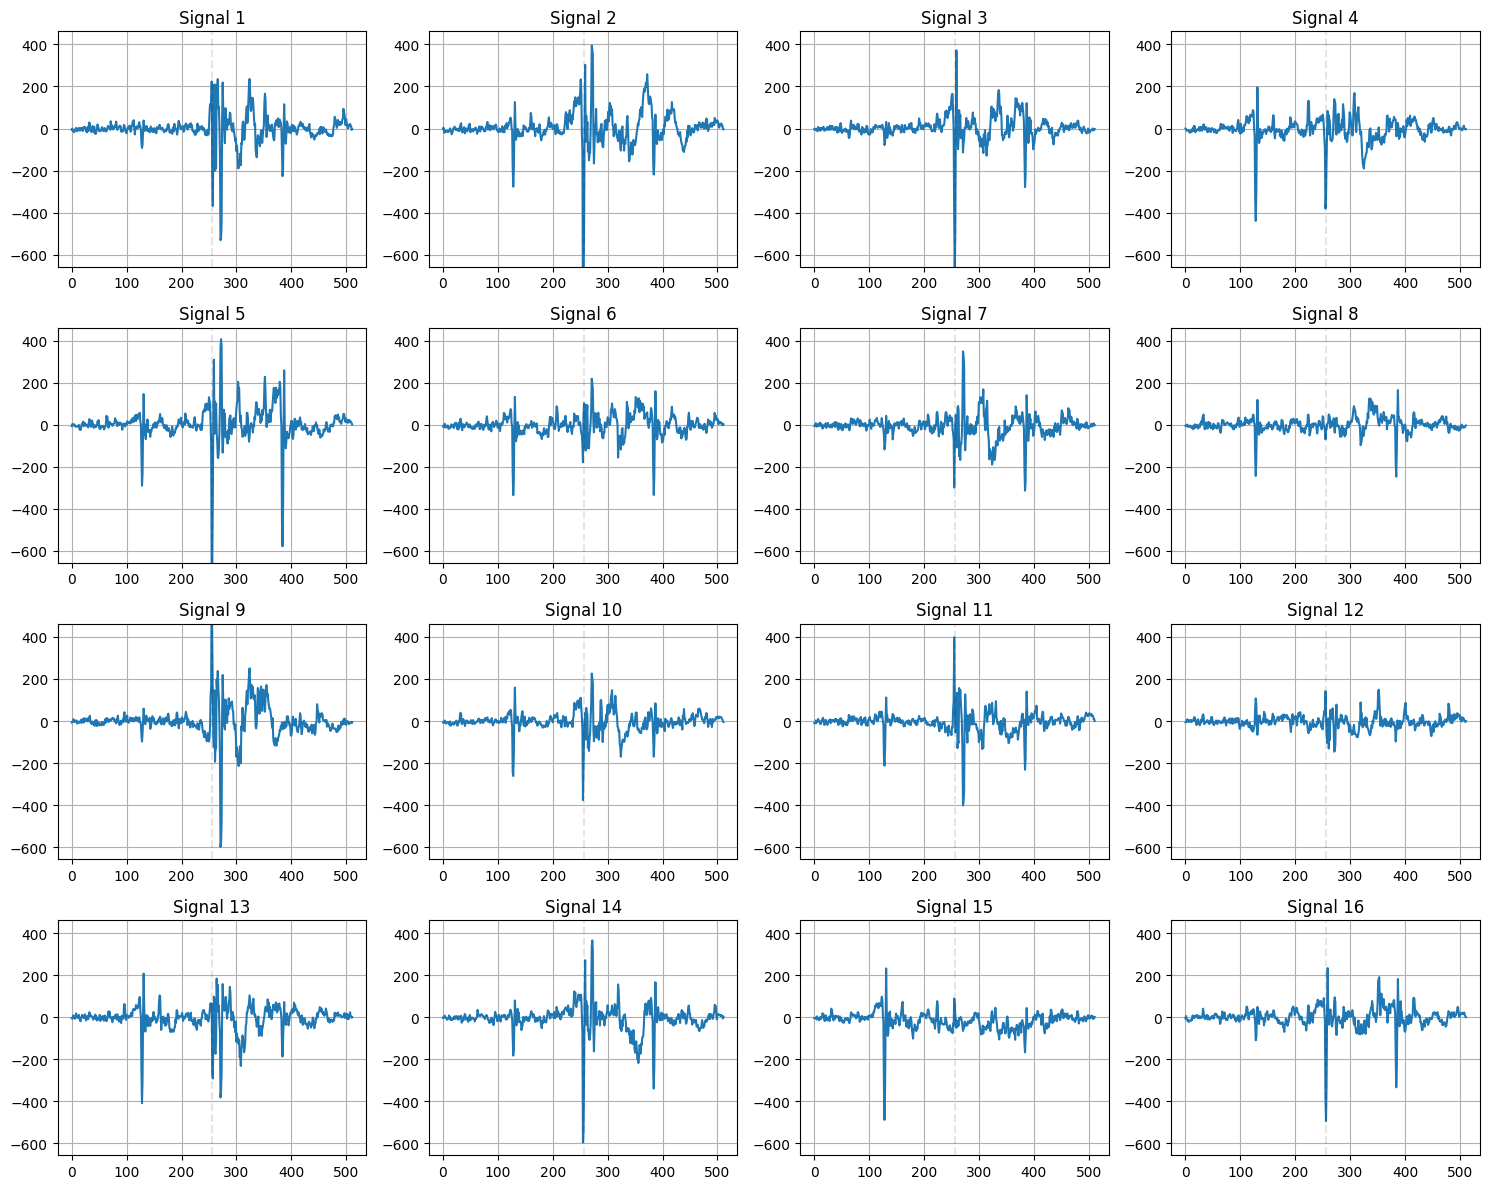

[13/20][0/188]	Loss_D: 0.5497	Loss_G: 2.1642	D(x): 0.1328	D(G(z)): 0.8229 / 0.7227
[13/20][50/188]	Loss_D: 0.9364	Loss_G: 3.0324	D(x): 0.1688	D(G(z)): 0.8441 / 0.7899
[13/20][100/188]	Loss_D: 0.7386	Loss_G: 2.3873	D(x): 0.1704	D(G(z)): 0.7865 / 0.7811
[13/20][150/188]	Loss_D: 0.7325	Loss_G: 3.3994	D(x): 0.0699	D(G(z)): 0.7754 / 0.8138


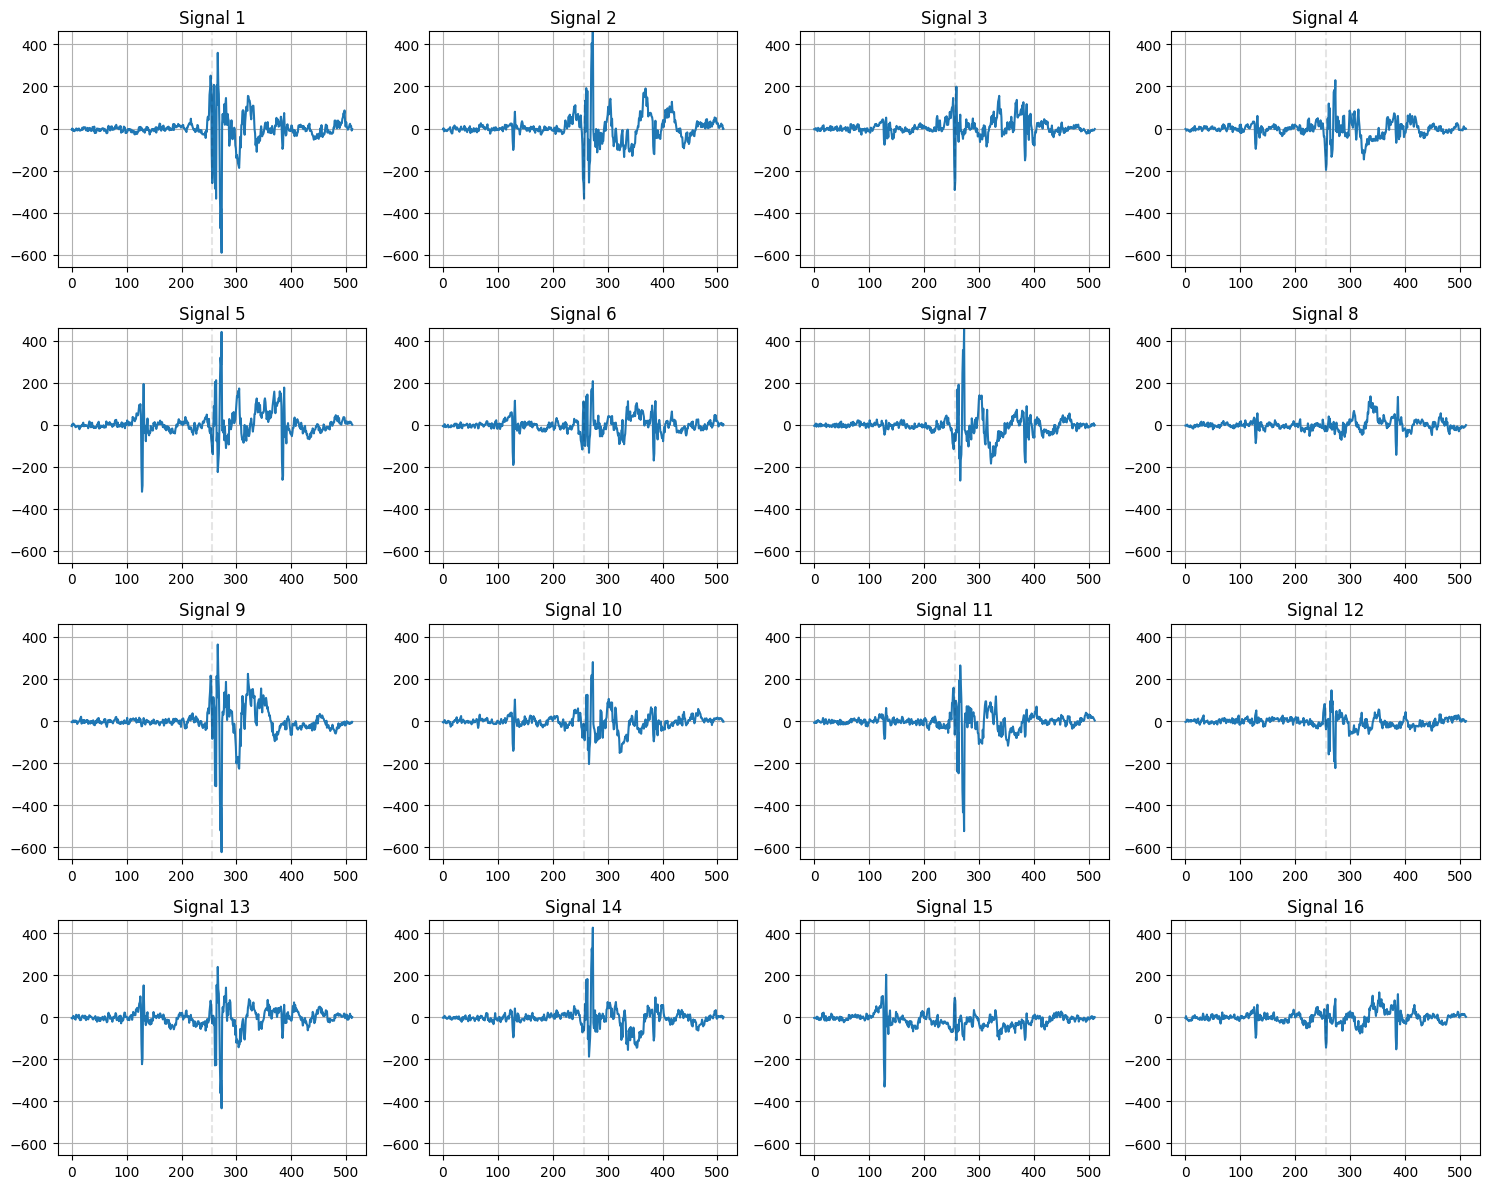

[14/20][0/188]	Loss_D: 0.5992	Loss_G: 2.5056	D(x): 0.1300	D(G(z)): 0.7587 / 0.7834
[14/20][50/188]	Loss_D: 1.0599	Loss_G: 1.9517	D(x): 0.1115	D(G(z)): 0.7856 / 0.7345
[14/20][100/188]	Loss_D: 0.6834	Loss_G: 2.8195	D(x): 0.1857	D(G(z)): 0.8529 / 0.8258
[14/20][150/188]	Loss_D: 0.9326	Loss_G: 4.5726	D(x): 0.0849	D(G(z)): 0.8411 / 0.9127


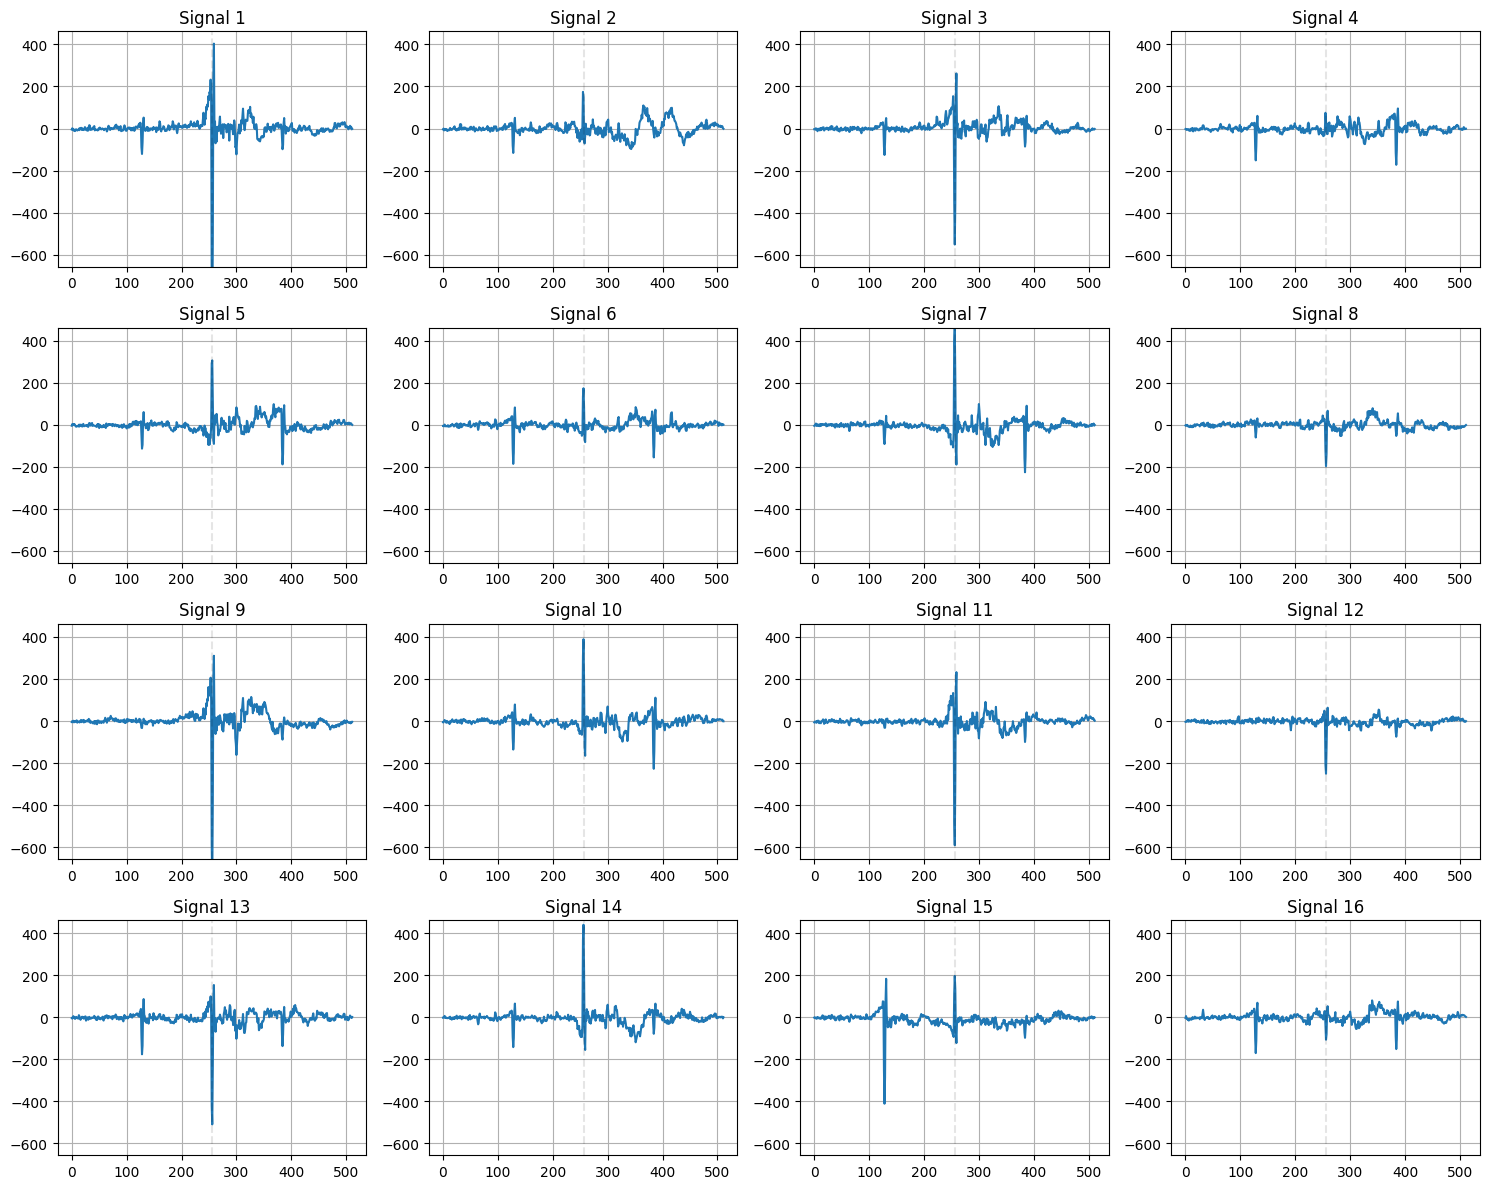

[15/20][0/188]	Loss_D: 0.8664	Loss_G: 2.3743	D(x): 0.1422	D(G(z)): 0.7566 / 0.7754
[15/20][50/188]	Loss_D: 0.7671	Loss_G: 2.2960	D(x): 0.1570	D(G(z)): 0.8006 / 0.7594
[15/20][100/188]	Loss_D: 0.5194	Loss_G: 2.9464	D(x): 0.0500	D(G(z)): 0.8418 / 0.7686
[15/20][150/188]	Loss_D: 0.6558	Loss_G: 2.8660	D(x): 0.1533	D(G(z)): 0.7877 / 0.8455


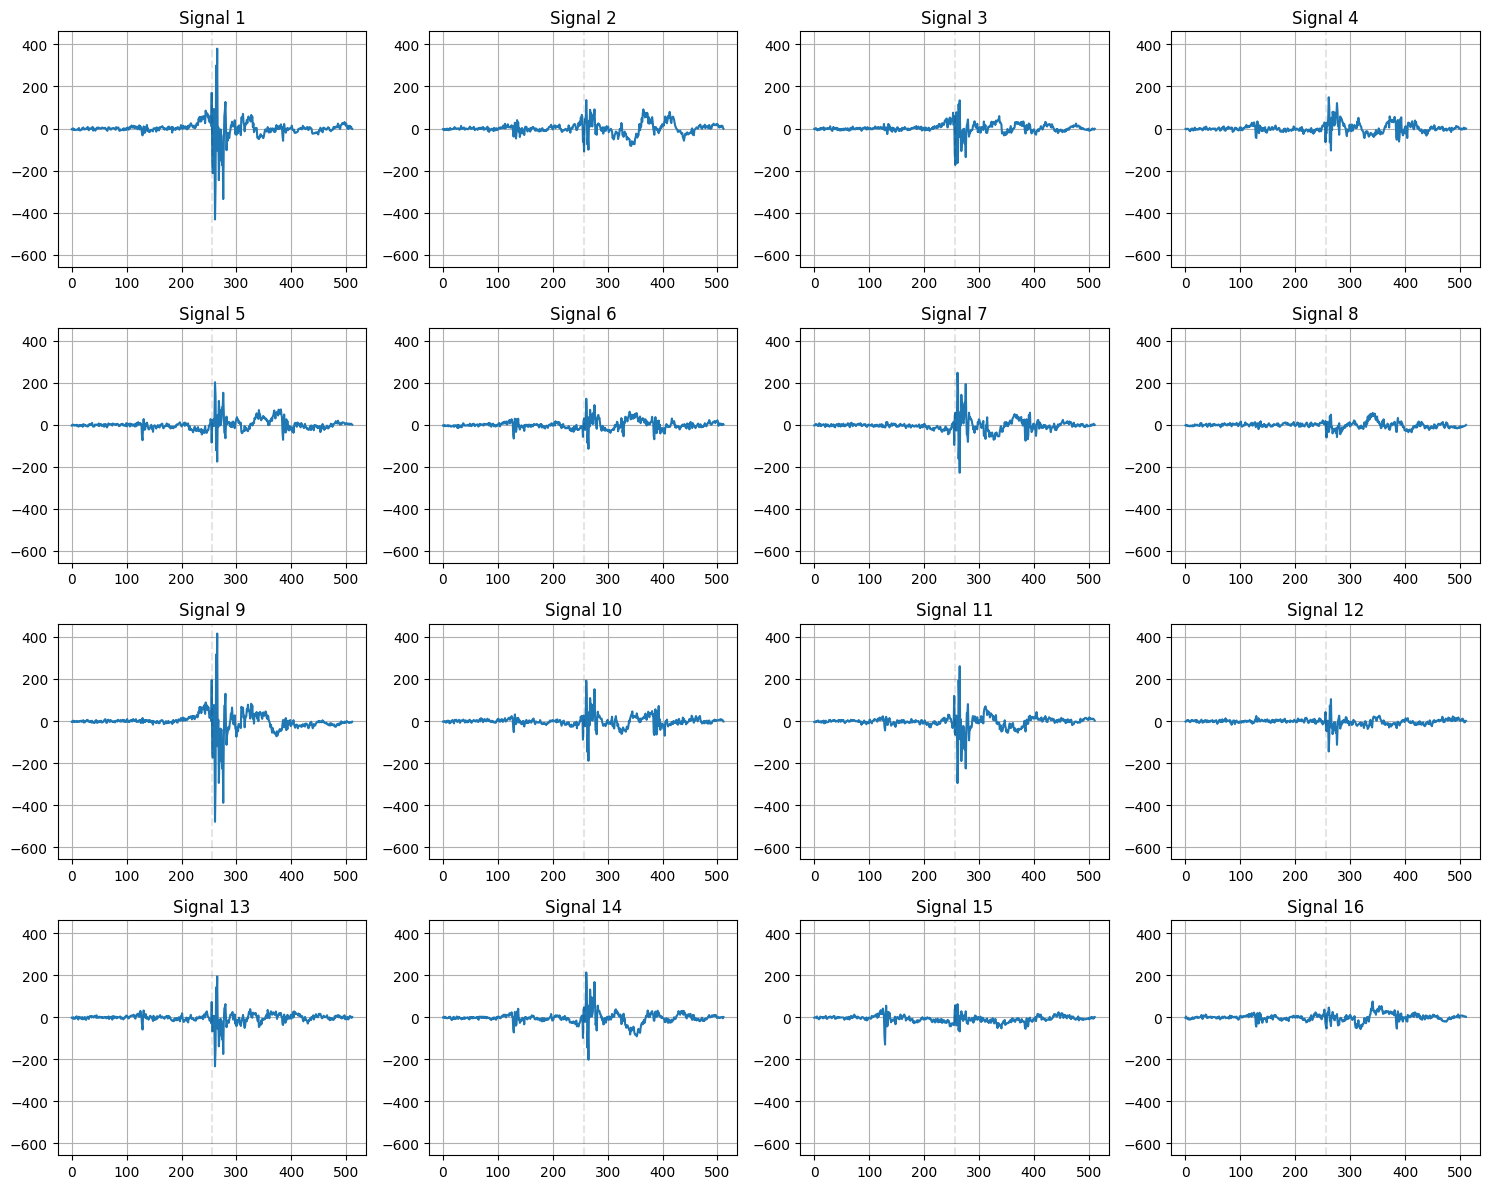

[16/20][0/188]	Loss_D: 0.6536	Loss_G: 1.8467	D(x): 0.1747	D(G(z)): 0.8227 / 0.7150
[16/20][50/188]	Loss_D: 0.8115	Loss_G: 1.9439	D(x): 0.1915	D(G(z)): 0.8166 / 0.7317
[16/20][100/188]	Loss_D: 0.5422	Loss_G: 1.9919	D(x): 0.1582	D(G(z)): 0.7952 / 0.7412
[16/20][150/188]	Loss_D: 0.4959	Loss_G: 4.2999	D(x): 0.1095	D(G(z)): 0.7573 / 0.9226


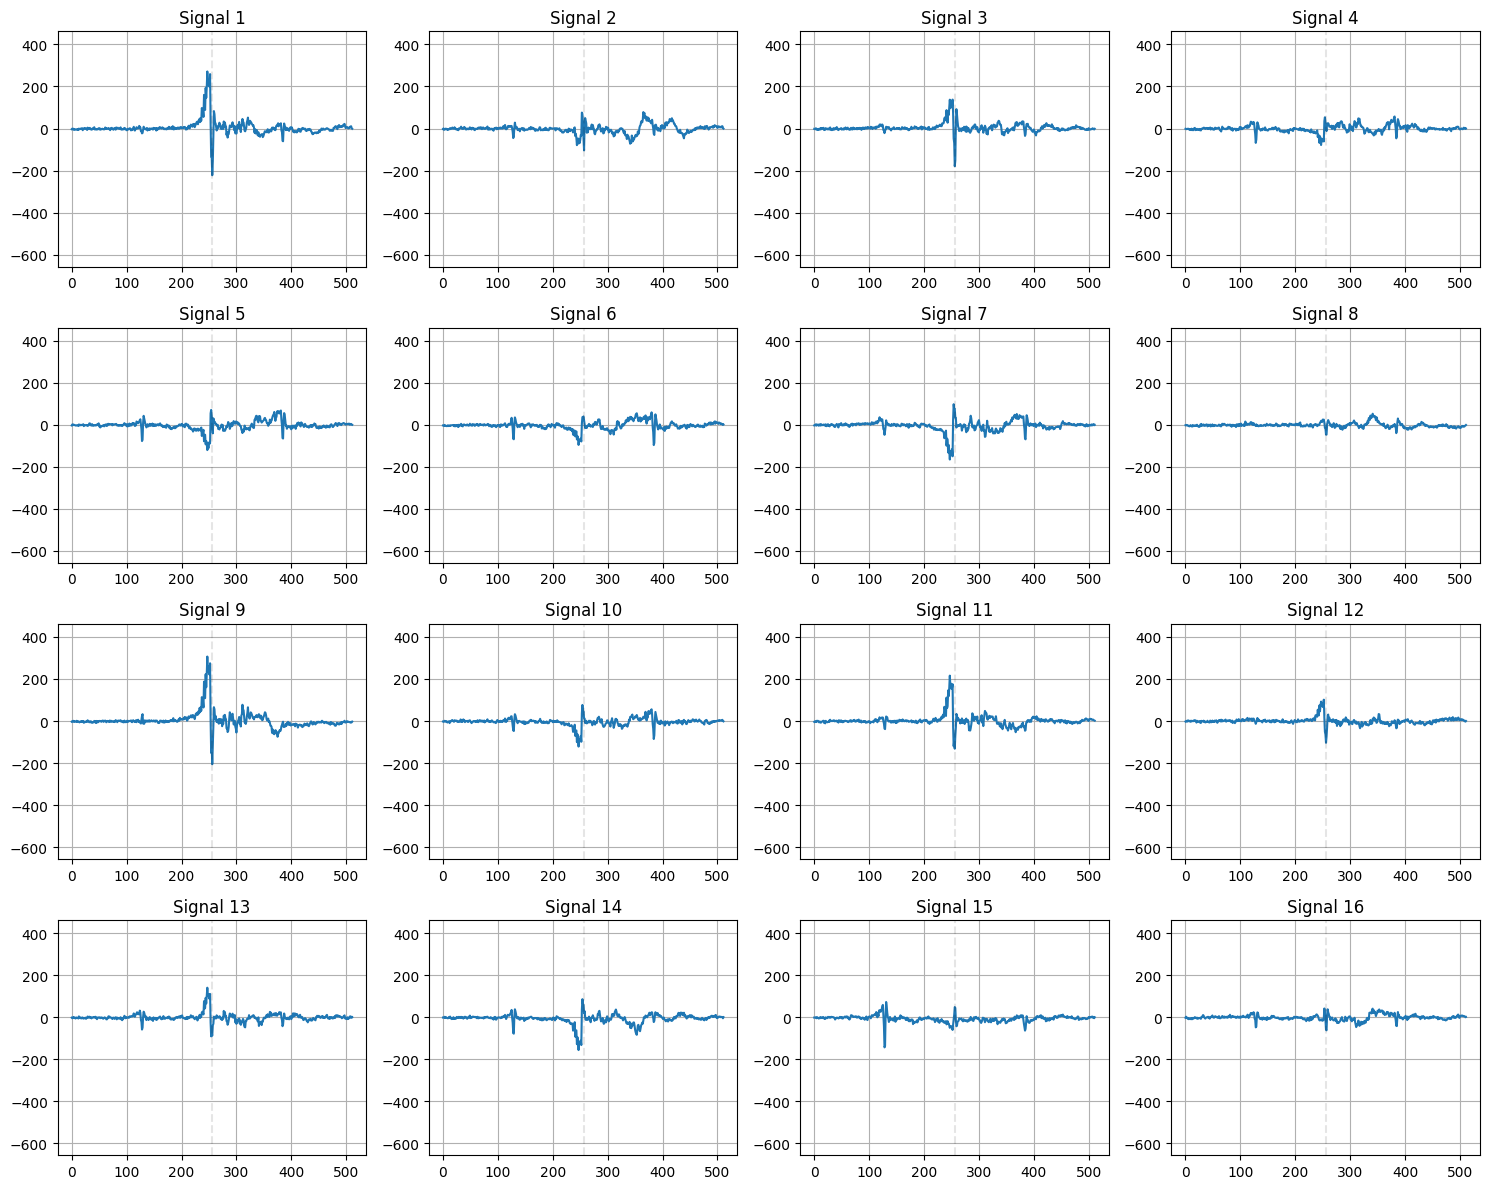

[17/20][0/188]	Loss_D: 0.9256	Loss_G: 2.7968	D(x): 0.1602	D(G(z)): 0.7774 / 0.8169
[17/20][50/188]	Loss_D: 0.9316	Loss_G: 3.1229	D(x): 0.1207	D(G(z)): 0.8083 / 0.8256
[17/20][100/188]	Loss_D: 0.6902	Loss_G: 2.9614	D(x): 0.1776	D(G(z)): 0.8290 / 0.7912
[17/20][150/188]	Loss_D: 0.7723	Loss_G: 1.5275	D(x): 0.0799	D(G(z)): 0.6070 / 0.6546


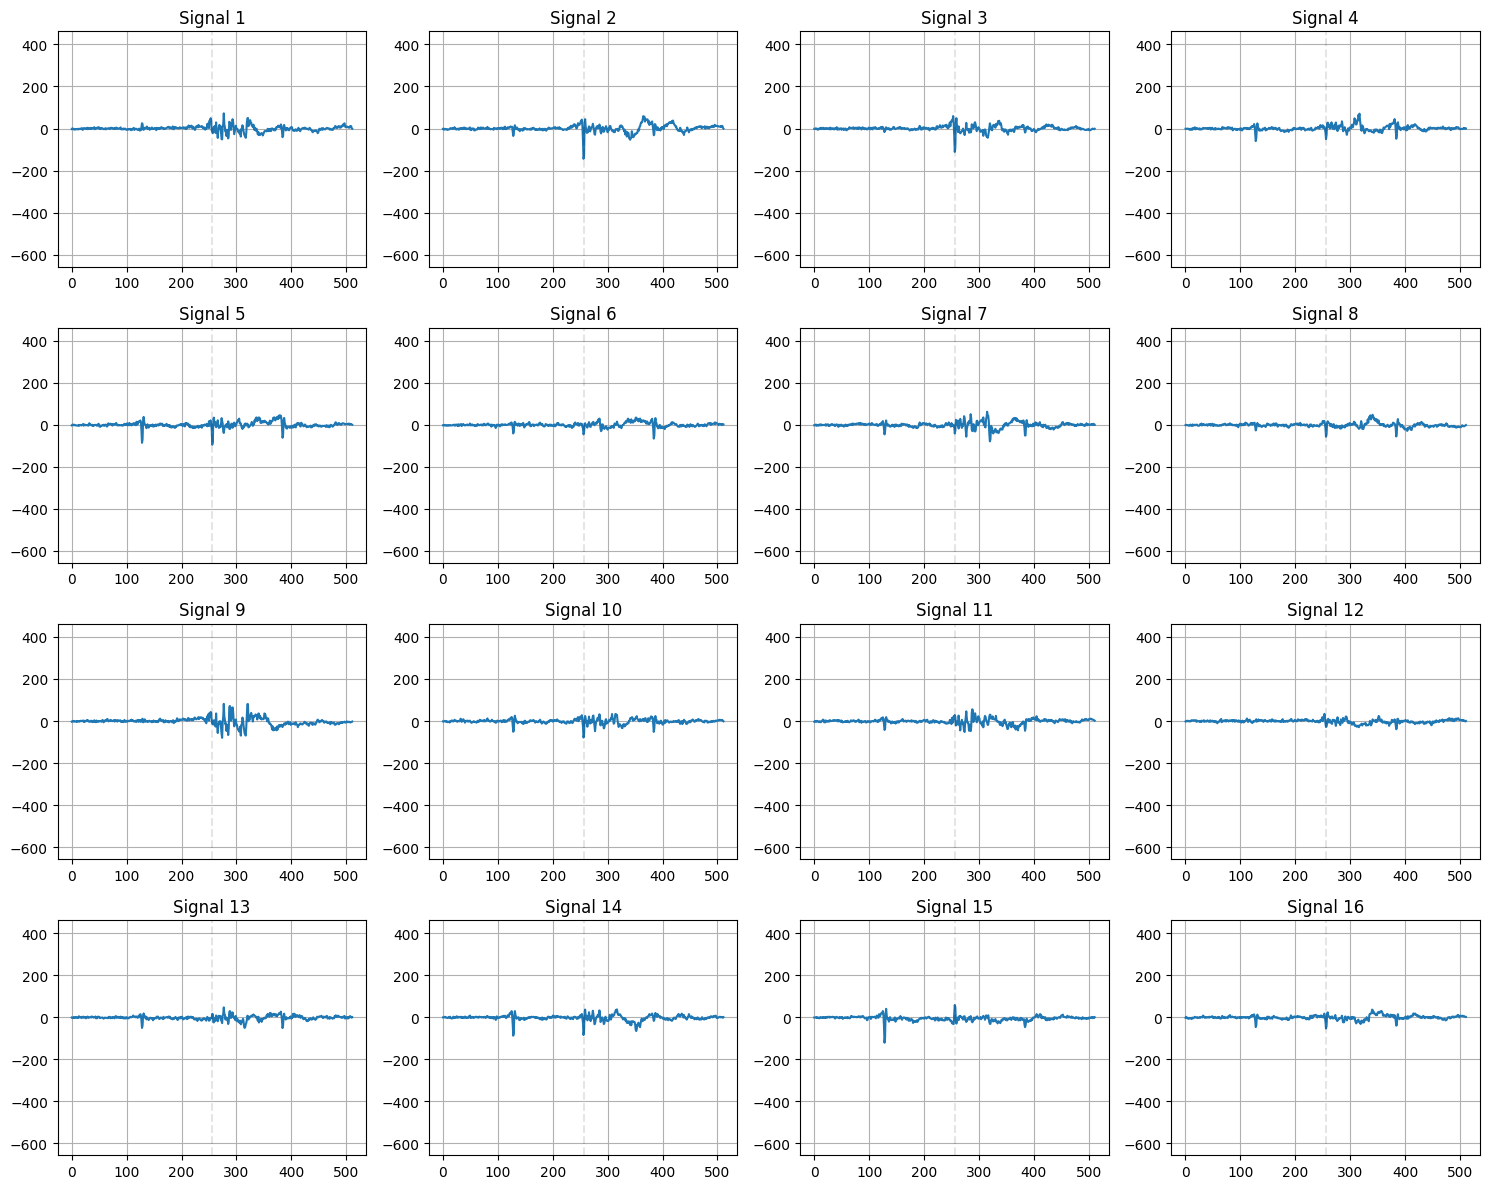

[18/20][0/188]	Loss_D: 0.5943	Loss_G: 3.1972	D(x): 0.1448	D(G(z)): 0.7660 / 0.7787
[18/20][50/188]	Loss_D: 0.7089	Loss_G: 3.0417	D(x): 0.1430	D(G(z)): 0.6345 / 0.8232
[18/20][100/188]	Loss_D: 0.6564	Loss_G: 2.5697	D(x): 0.0958	D(G(z)): 0.7698 / 0.7704
[18/20][150/188]	Loss_D: 0.8900	Loss_G: 2.1210	D(x): 0.1136	D(G(z)): 0.8323 / 0.7426


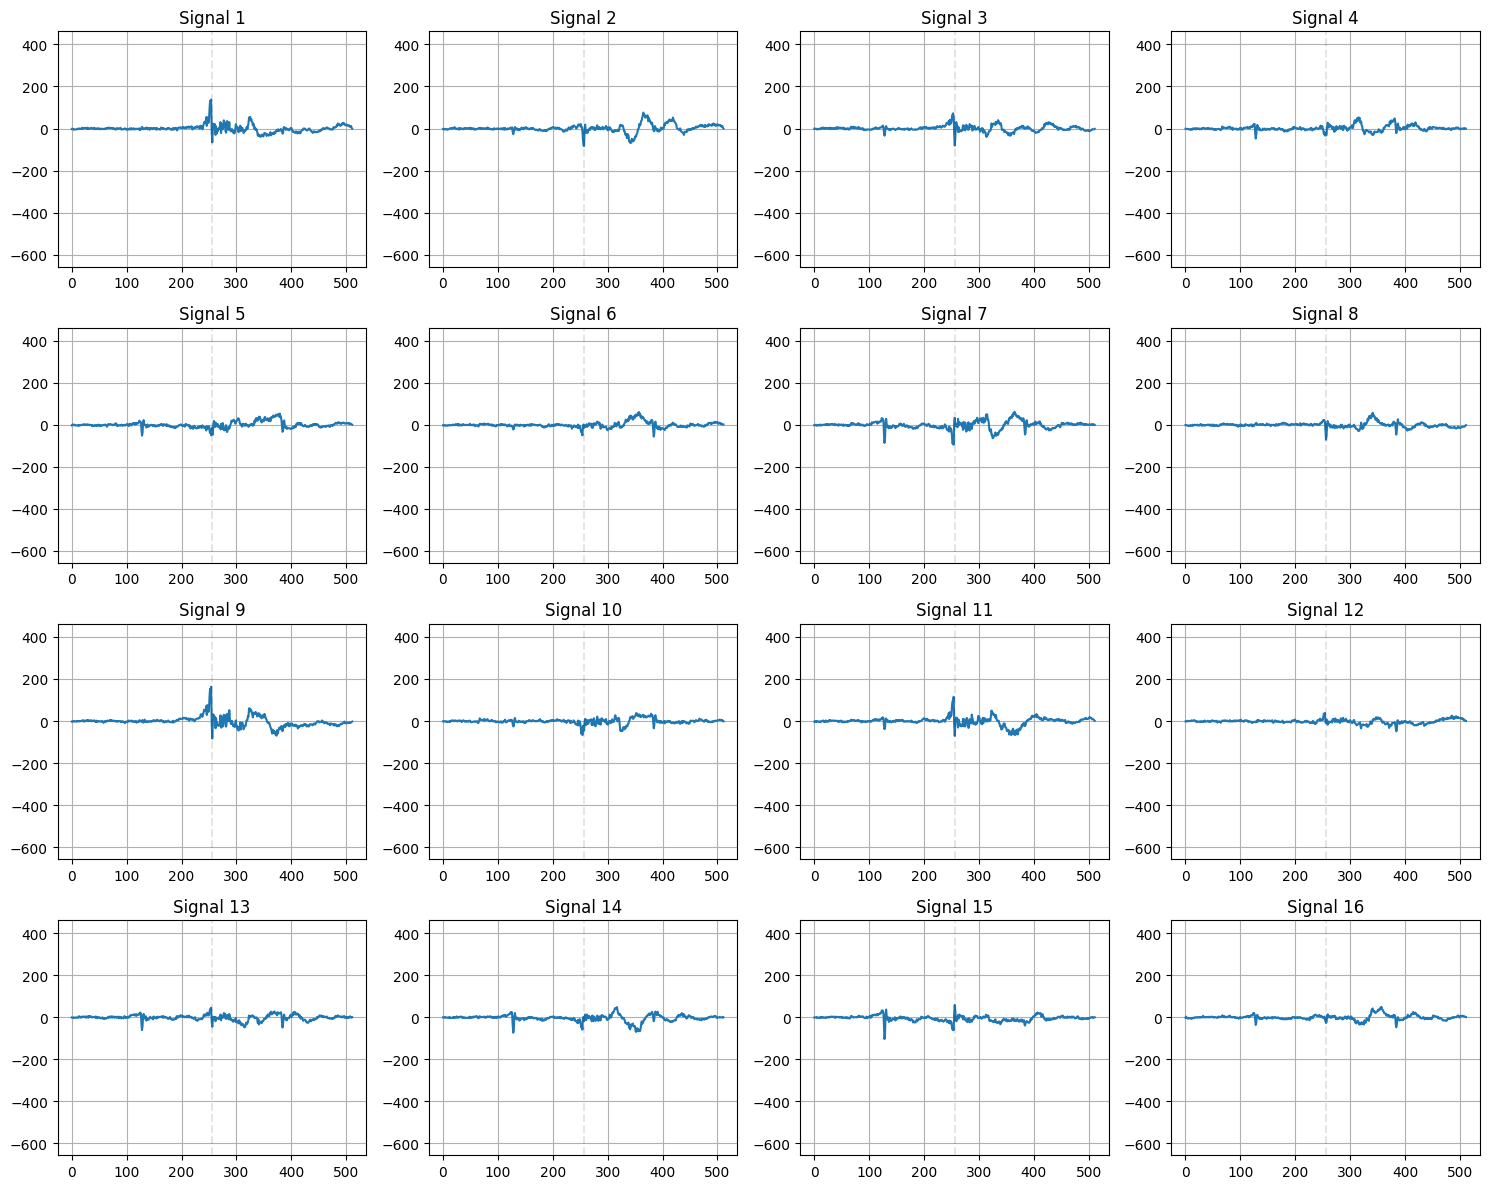

[19/20][0/188]	Loss_D: 0.7901	Loss_G: 3.4684	D(x): 0.1563	D(G(z)): 0.7051 / 0.9042
[19/20][50/188]	Loss_D: 0.8689	Loss_G: 3.2323	D(x): 0.1484	D(G(z)): 0.8201 / 0.8194
[19/20][100/188]	Loss_D: 0.8598	Loss_G: 3.3552	D(x): 0.1926	D(G(z)): 0.7447 / 0.8891
[19/20][150/188]	Loss_D: 0.3627	Loss_G: 2.3608	D(x): 0.0316	D(G(z)): 0.7396 / 0.8226


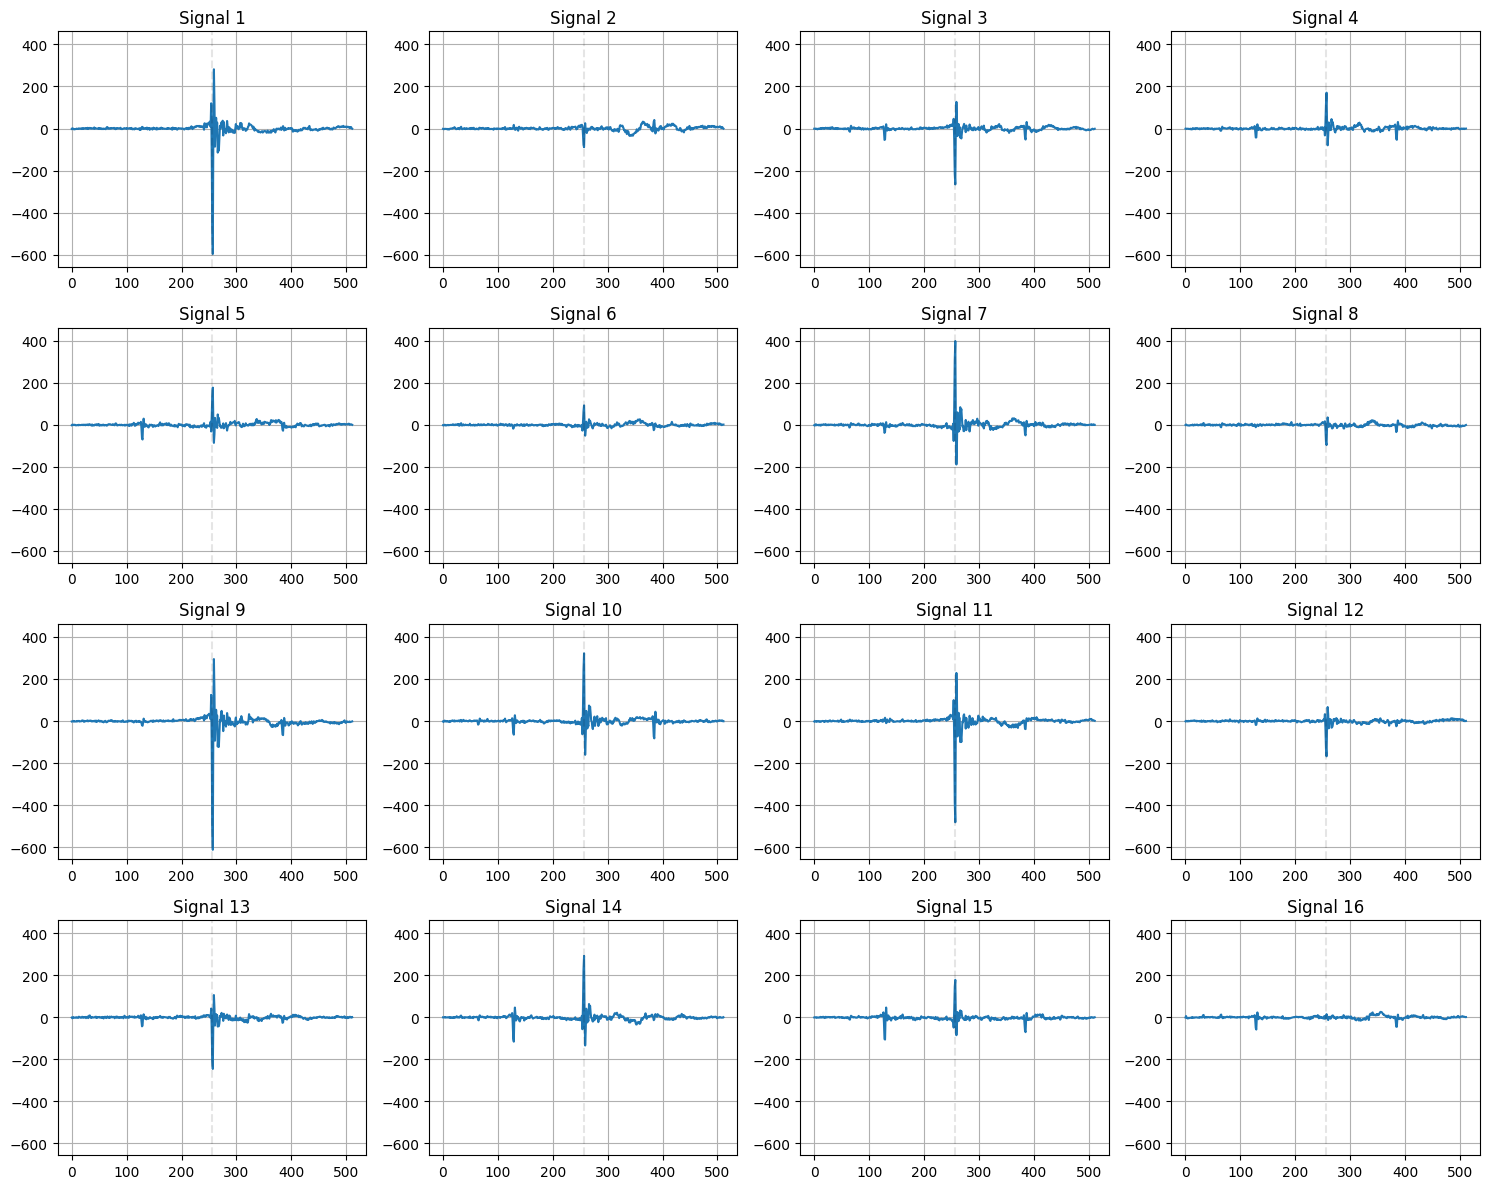

In [178]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 

    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

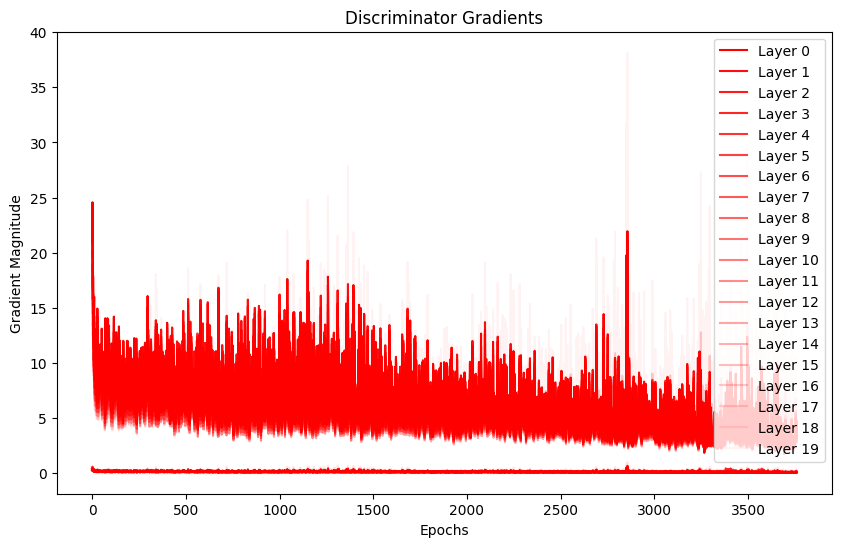

In [179]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

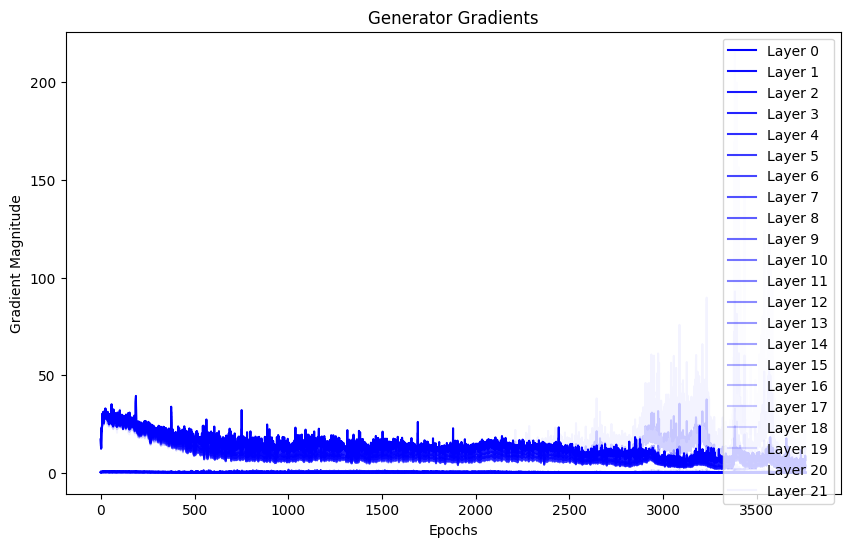

In [180]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

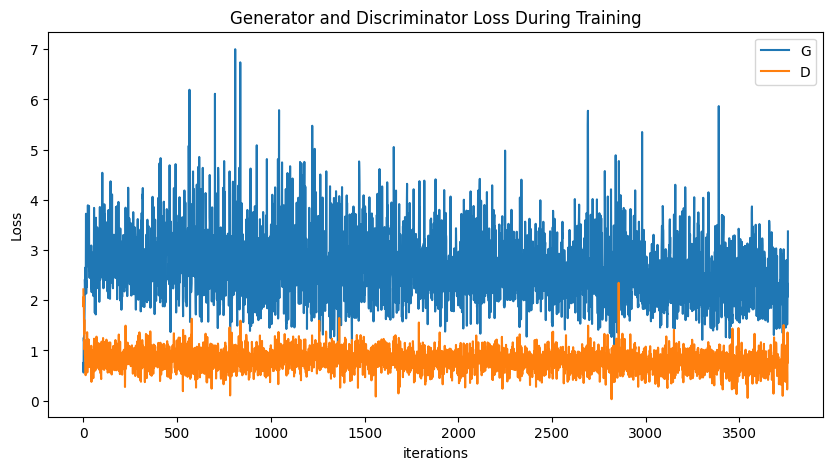

In [181]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


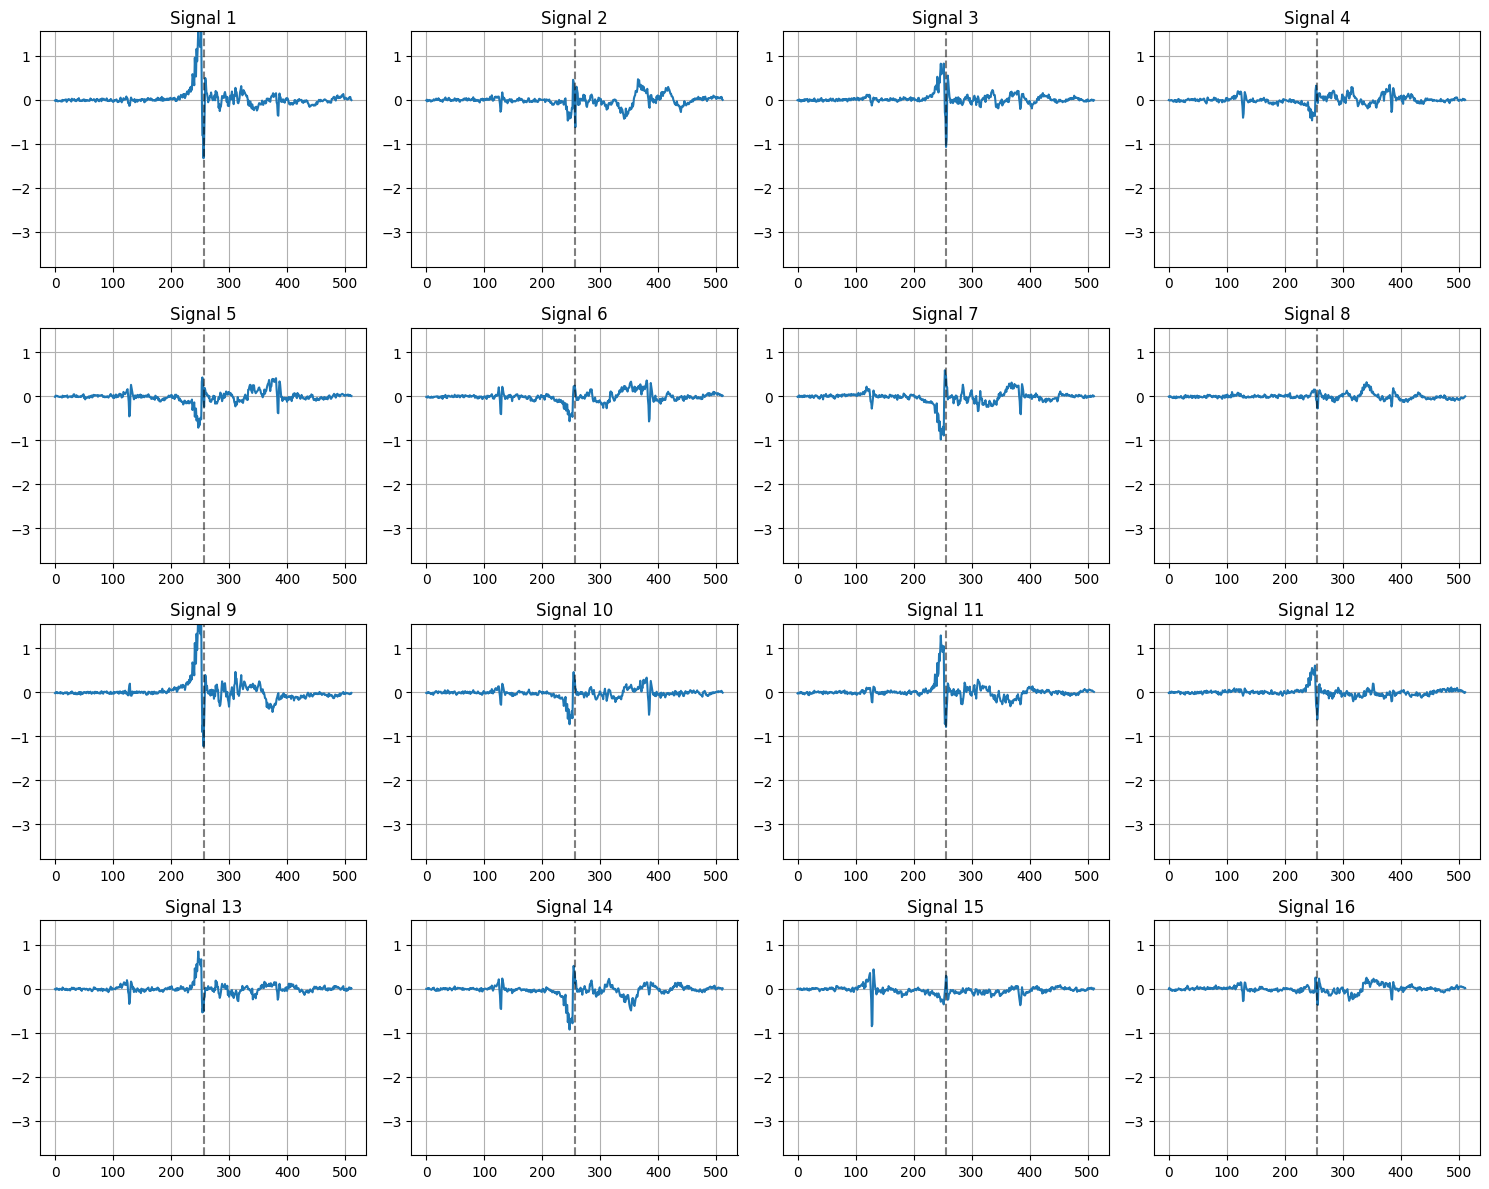

In [182]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [183]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [184]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
